# Predicting churn

This is a juypter notebook solution on analysing and predicting the credit card customer churn dataset from Kaggle. The tasks included are:

- 1) perform exploratory data analysis and share any insights found
- 2) build a tree-based ML model to predict customer churn
- 3) test the model with the unseen dataset and report any findings on the results

$\color{green} {\text{Note: I ended up spending around 2 days (~18 hours) working on these tasks.}}$

# show the versions of the open source libraries used

In [1]:
# show the versions of imported libraries

import sys 
print("Python version: {}". format(sys.version))

import pandas as pd 
print("pandas version: {}". format(pd.__version__))

import matplotlib 
import matplotlib.pyplot as plt
print("matplotlib version: {}". format(matplotlib.__version__))

import seaborn as sns
print("seaborn version: {}". format(sns.__version__))

import numpy as np 
print("NumPy version: {}". format(np.__version__))

import scipy as sp 
print("SciPy version: {}". format(sp.__version__)) 

import missingno as msno
print("Missingno version: {}". format(msno.__version__)) 

import IPython
from IPython import display # for pretty printing of dataframes in Jupyter notebook
print("IPython version: {}". format(IPython.__version__)) 

import sklearn 
print("scikit-learn version: {}". format(sklearn.__version__))

Python version: 3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
pandas version: 0.24.2
matplotlib version: 3.1.2
seaborn version: 0.11.1
NumPy version: 1.16.4
SciPy version: 1.4.1
Missingno version: 0.4.2
IPython version: 7.6.1
scikit-learn version: 0.24.2


In [2]:
# Ignore Warning in IPython
import warnings
warnings.filterwarnings('ignore')

## 1) Exploratory data analysis (EDA)

# Brief inspection

This dataset is expected to be about customers of some credit card products (of a bank) as suggested by the information given in the data dictionary. We will start by performing exploratory data analysis (EDA) on this dataset.

Let us first load, get some very basic information about each variables (e.g. non-NaN counts, dtype, etc) and have a brief look at the first few entries of the (training) dataset, i.e. `churn_data.csv`.

In [3]:
# load the dataset
churn_raw_data = pd.read_csv('datasets/churn_data.csv')

In [4]:
# first 5 rows of the dataset
churn_raw_data.head()

CLIENTNUM  Customer_Age Gender  Dependent_count Education_Level  \
0  719999508.0          37.0      M              3.0         Unknown   
1  718982058.0          37.0      M              3.0        Graduate   
2  714892533.0          26.0      M              0.0         Unknown   
3  712084383.0          63.0      M              1.0        Graduate   
4  718768158.0          57.0      M              1.0         College   

  Marital_Status Income_Category Card_Category  Months_on_book  \
0        Married     $60K - $80K          Blue            24.0   
1       Divorced     $40K - $60K          Blue            36.0   
2         Single         Unknown          Blue            16.0   
3         Single  Less than $40K          Blue            56.0   
4         Single     $40K - $60K          Blue            48.0   

   Total_Relationship_Count  ...  Contacts_Count_12_mon  Credit_Limit  \
0                       3.0  ...                    2.0       11894.0   
1                       5.0  ...                    0.0        5987.0   
2                       5.0  ...                    2.0        3877.0   
3                       4.0  ...                    2.0        7936.0   
4                       3.0  ...                    2.0        3539.0   

   Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0                816.0          11078.0                 1.561   
1               1405.0           4582.0                 0.952   
2                  0.0           3877.0                 0.773   
3               2081.0              NaN                 0.941   
4                  0.0           3539.0                 0.781   

   Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  \
0           2438.0            45.0                0.607   
1           4011.0            72.0                0.674   
2           2473.0            33.0                0.833   
3           4247.0            81.0                0.841   
4           1336.0            23.0                0.211   

   Avg_Utilization_Ratio     Attrition_Flag  
0                  0.069  Existing Customer  
1                  0.235  Existing Customer  
2                  0.000  Existing Customer  
3                  0.262  Existing Customer  
4                  0.000  Existing Customer  

[5 rows x 21 columns]

In [5]:
# show some very basic info about the dataset
churn_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9620 entries, 0 to 9619
Data columns (total 21 columns):
CLIENTNUM                   9520 non-null float64
Customer_Age                9520 non-null float64
Gender                      9520 non-null object
Dependent_count             9520 non-null float64
Education_Level             9520 non-null object
Marital_Status              9520 non-null object
Income_Category             9520 non-null object
Card_Category               9520 non-null object
Months_on_book              9520 non-null float64
Total_Relationship_Count    9520 non-null float64
Months_Inactive_12_mon      9520 non-null float64
Contacts_Count_12_mon       9520 non-null float64
Credit_Limit                9520 non-null float64
Total_Revolving_Bal         9520 non-null float64
Avg_Open_To_Buy             7620 non-null float64
Total_Amt_Chng_Q4_Q1        9520 non-null float64
Total_Trans_Amt             9520 non-null float64
Total_Trans_Ct              9520 non-null float6

From the above, we can see there are a total of 9620 entries, with all the variables except `[Avg_Open_To_Buy, Attrition_Flag]` having around `~1%` (i.e 100) missing entries. On the other hand, the variable `Avg_Open_To_Buy` (i.e. Open to Buy Credit Line (Average of last 12 months) has around `~20%` (i.e 2000) missing entries, whereas the target variable `Attrition_Flag` (i.e. customer churned flag) entries are all non-null.

For dtypes, majority of the variables are numeric (float/integer), except `[Gender, Education_Level, Marital_Status, Income_Category, Card_Category, Attrition_Flag]` where they are string-like entries.

# Check entries with missing ID

Before we proceed further, let us first investigate those entries with missing customer ID. In particular, we would like to find out if those entries contain any non-null feature variables (except the target `Attrition_Flag`) or not. 

In [6]:
# Filter out the entries with missing customer
is_id_missing = churn_raw_data['CLIENTNUM'].isna()
customer_with_id_missing = churn_raw_data[is_id_missing]

In [7]:
customer_with_id_missing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 102 to 9611
Data columns (total 21 columns):
CLIENTNUM                   0 non-null float64
Customer_Age                0 non-null float64
Gender                      0 non-null object
Dependent_count             0 non-null float64
Education_Level             0 non-null object
Marital_Status              0 non-null object
Income_Category             0 non-null object
Card_Category               0 non-null object
Months_on_book              0 non-null float64
Total_Relationship_Count    0 non-null float64
Months_Inactive_12_mon      0 non-null float64
Contacts_Count_12_mon       0 non-null float64
Credit_Limit                0 non-null float64
Total_Revolving_Bal         0 non-null float64
Avg_Open_To_Buy             0 non-null float64
Total_Amt_Chng_Q4_Q1        0 non-null float64
Total_Trans_Amt             0 non-null float64
Total_Trans_Ct              0 non-null float64
Total_Ct_Chng_Q4_Q1         0 non-null float64
Avg_

In [8]:
# check the corresponnding customer churn target variable entries 
# (where customer ID is missing)
customer_with_id_missing['Attrition_Flag'].value_counts()

Existing Customer    87
Attrited Customer    13
Name: Attrition_Flag, dtype: int64

From the above, we can see for those 100 entries with missing customer ID, all feature variables (except the target variable churn, i.e. `Attrition_Flag`) are null/missing as well. We may therefore conclude that these missing entries are likely to be caused by errors during data querying or data merging in the first place. 

These missing entries are likely to be of little use for building predictive models and thus from here onwards we will drop them in the following analysis.

In [9]:
# remove entries with missing customer ID
churn_data_with_id = churn_raw_data[~is_id_missing]

# Check duplicate entries

We now focus on the entries with non-null customer ID. Before we proceed to do exploratory data analysis on these data, let us check there is no duplicate entries first. Here we investigate this by checking if there exists any repeated customer ID (i.e. `CLIENTNUM`) or duplicated row entries (except customer ID) in the dataset. 

In [10]:
# check to ensure no repeated customer ID
customer_ids = churn_data_with_id['CLIENTNUM']
number_of_rows = len(customer_ids)
number_of_unique_ids = customer_ids.nunique()

if number_of_rows == number_of_unique_ids:
    print(f'All {number_of_rows} customer IDs are unique')
else:
    number_of_repeated_ids = number_of_rows - number_of_unique_ids
    print(f'There exists some {number_of_repeated_ids} repeated customer IDs')

All 9520 customer IDs are unique


In [11]:
# check to ensure no duplicated row entries (except customer ID)
check_duplicated = churn_data_with_id.iloc[:, 1:].duplicated()
sum(check_duplicated)

0

From the above, it can be seen the customer ID and all row entries are indeed unique in these non-null customer ID entries.

# Basic inference

Now let's start with some basic inference, i.e. inspecting the number of data points, number of missing entries and dtypes for each features. We will also briefly check validity of each features here.

We can see that the remaining entries have 9520 customers, now with only missing entries in `Avg_Open_To_Buy`.

In [12]:
churn_data_with_id.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9520 entries, 0 to 9619
Data columns (total 21 columns):
CLIENTNUM                   9520 non-null float64
Customer_Age                9520 non-null float64
Gender                      9520 non-null object
Dependent_count             9520 non-null float64
Education_Level             9520 non-null object
Marital_Status              9520 non-null object
Income_Category             9520 non-null object
Card_Category               9520 non-null object
Months_on_book              9520 non-null float64
Total_Relationship_Count    9520 non-null float64
Months_Inactive_12_mon      9520 non-null float64
Contacts_Count_12_mon       9520 non-null float64
Credit_Limit                9520 non-null float64
Total_Revolving_Bal         9520 non-null float64
Avg_Open_To_Buy             7620 non-null float64
Total_Amt_Chng_Q4_Q1        9520 non-null float64
Total_Trans_Amt             9520 non-null float64
Total_Trans_Ct              9520 non-null float6

# Validity check

Next we go on to check the validality of the non-null entries of the variables in the dataset.
Though it appears there are no missing entries now for almost all of the variables, there is still a possibility that some of the non-null entries are in fact invalid which should be handled separately beforehand.

$\color{blue} {\text{Categorical/non-numerical variables}}$

We shall start with categorical/non-numerical variables first, i.e. `[Gender, Education_Level, Marital_Status, Income_Category, Card_Category, Attrition_Flag]`.

In [13]:
# list the non-null unique entries for each non-numeric variables
non_numeric_cols = [
    'Gender', 
    'Education_Level', 
    'Marital_Status', 
    'Income_Category', 
    'Card_Category', 
    'Attrition_Flag'
]

print('List of non-null unique entries for non-numerical variables\n')
for col in non_numeric_cols:
    unique_values = churn_data_with_id[col].unique().tolist()
    print(f'{col}: {unique_values}')

List of non-null unique entries for non-numerical variables

Gender: ['M', 'F']
Education_Level: ['Unknown', 'Graduate', 'College', 'High School', 'Post-Graduate', 'Uneducated', 'Doctorate']
Marital_Status: ['Married', 'Divorced', 'Single', 'Unknown']
Income_Category: ['$60K - $80K', '$40K - $60K', 'Unknown', 'Less than $40K', '$80K - $120K', '$120K +']
Card_Category: ['Blue', 'Silver', 'Gold', 'Platinum']
Attrition_Flag: ['Existing Customer', 'Attrited Customer']


From the above, we can see the non-null entries found for these categorical variables in the dataset do appear valid and consistent with the description in the data dictionary. 

There are some `Unknown` entries for `[Education_Level, Marital_Status, Income_Category]`, which depends on the underlying reasons, they may in fact be considered as `missing` entries. We will come back to discuss on that in the next section.

$\color{blue} {\text{Numerical variables}}$

Next we study numerical variables and verfiy if the individual entries lie within the reasonably acceptable range for each corresponding variables.

In [14]:
churn_data_with_id.describe()

CLIENTNUM  Customer_Age  Dependent_count  Months_on_book  \
count  9.520000e+03   9520.000000      9520.000000     9520.000000   
mean   7.392843e+08     46.334874         2.348109       35.933613   
std    3.688388e+07      8.029102         1.299162        7.977988   
min    7.080821e+08     26.000000         0.000000       13.000000   
25%    7.130697e+08     41.000000         1.000000       31.000000   
50%    7.179767e+08     46.000000         2.000000       36.000000   
75%    7.732617e+08     52.000000         3.000000       40.000000   
max    8.283431e+08     73.000000         5.000000       56.000000   

       Total_Relationship_Count  Months_Inactive_12_mon  \
count               9520.000000             9520.000000   
mean                   3.808403                2.345693   
std                    1.557611                1.011610   
min                    1.000000                0.000000   
25%                    3.000000                2.000000   
50%                    4.000000                2.000000   
75%                    5.000000                3.000000   
max                    6.000000                6.000000   

       Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
count            9520.000000   9520.000000          9520.000000   
mean                2.453887   8604.085389          1162.837605   
std                 1.107508   9056.394383           813.249598   
min                 0.000000   1438.300000             0.000000   
25%                 2.000000   2550.000000           396.750000   
50%                 2.000000   4539.500000          1278.000000   
75%                 3.000000  10998.500000          1782.000000   
max                 6.000000  34516.000000          2517.000000   

       Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
count      7620.000000           9520.000000      9520.000000     9520.000000   
mean       7470.433255              0.760347      4390.698529       64.745483   
std        9084.029874              0.220522      3383.304617       23.427900   
min           3.000000              0.000000       510.000000       10.000000   
25%        1295.000000              0.631000      2153.000000       45.000000   
50%        3505.000000              0.737000      3889.000000       67.000000   
75%        9949.250000              0.860000      4738.000000       80.000000   
max       34516.000000              3.397000     18484.000000      139.000000   

       Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
count          9520.000000            9520.000000  
mean              0.711424               0.275465  
std               0.238675               0.275831  
min               0.000000               0.000000  
25%               0.581000               0.023000  
50%               0.700000               0.177000  
75%               0.818000               0.502250  
max               3.714000               0.999000

Comparing with the description given in the data dictionary, quick inspection suggests these numerical variables entries in the dataset do appear to be valid here, e.g. all entries are positive, `Customer_Age`, `Dependent_count` lie within reasonable range, etc.

# "Missing values" investigation

Before we move to study the statistics and correlation between the variables in the dataset. Let us first do some investigation on the "missing" values in the dataset and get some ideas on what may be the reasons behind having the "missing" values in the first place.

Here in this section we will consider `Unknown` entries in `[Education_Level, Marital_Status, Income_Category]` as `missing` and investigate if there are any patterns underneath those entries. Again we will ignore those 'trivial' missing entries where all variables but the `Attrition_Flag` are missing.

In [15]:
# Replace 'Unknown' entries with NaN for missing analysis
churn_data_with_id_replace_unknowns = churn_data_with_id.copy()
churn_data_with_id_replace_unknowns.replace('Unknown', np.nan, inplace=True)

In [16]:
churn_data_with_id_replace_unknowns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9520 entries, 0 to 9619
Data columns (total 21 columns):
CLIENTNUM                   9520 non-null float64
Customer_Age                9520 non-null float64
Gender                      9520 non-null object
Dependent_count             9520 non-null float64
Education_Level             8073 non-null object
Marital_Status              8819 non-null object
Income_Category             8468 non-null object
Card_Category               9520 non-null object
Months_on_book              9520 non-null float64
Total_Relationship_Count    9520 non-null float64
Months_Inactive_12_mon      9520 non-null float64
Contacts_Count_12_mon       9520 non-null float64
Credit_Limit                9520 non-null float64
Total_Revolving_Bal         9520 non-null float64
Avg_Open_To_Buy             7620 non-null float64
Total_Amt_Chng_Q4_Q1        9520 non-null float64
Total_Trans_Amt             9520 non-null float64
Total_Trans_Ct              9520 non-null float6

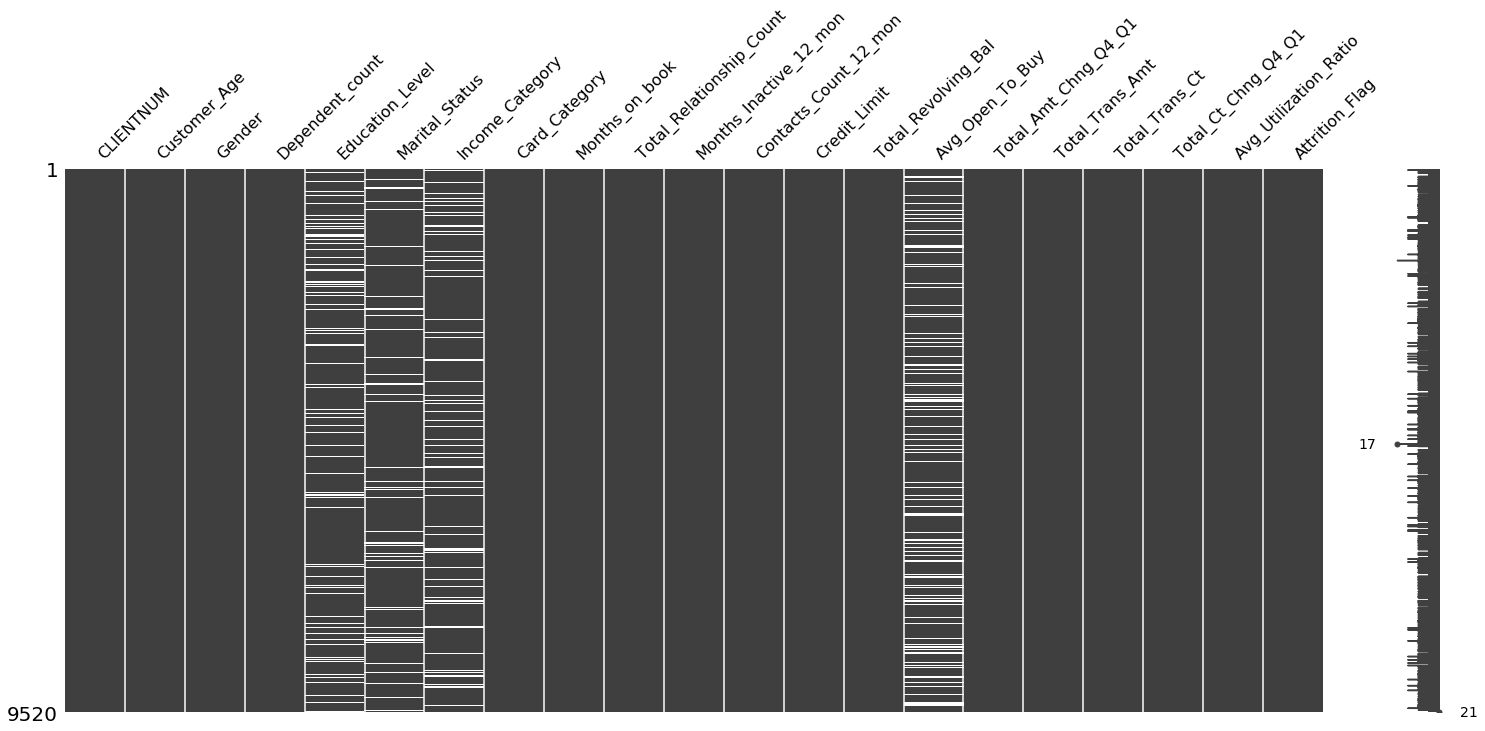

In [17]:
# missingness matrix, to investigate potential relation between missing values
msno.matrix(churn_data_with_id_replace_unknowns)

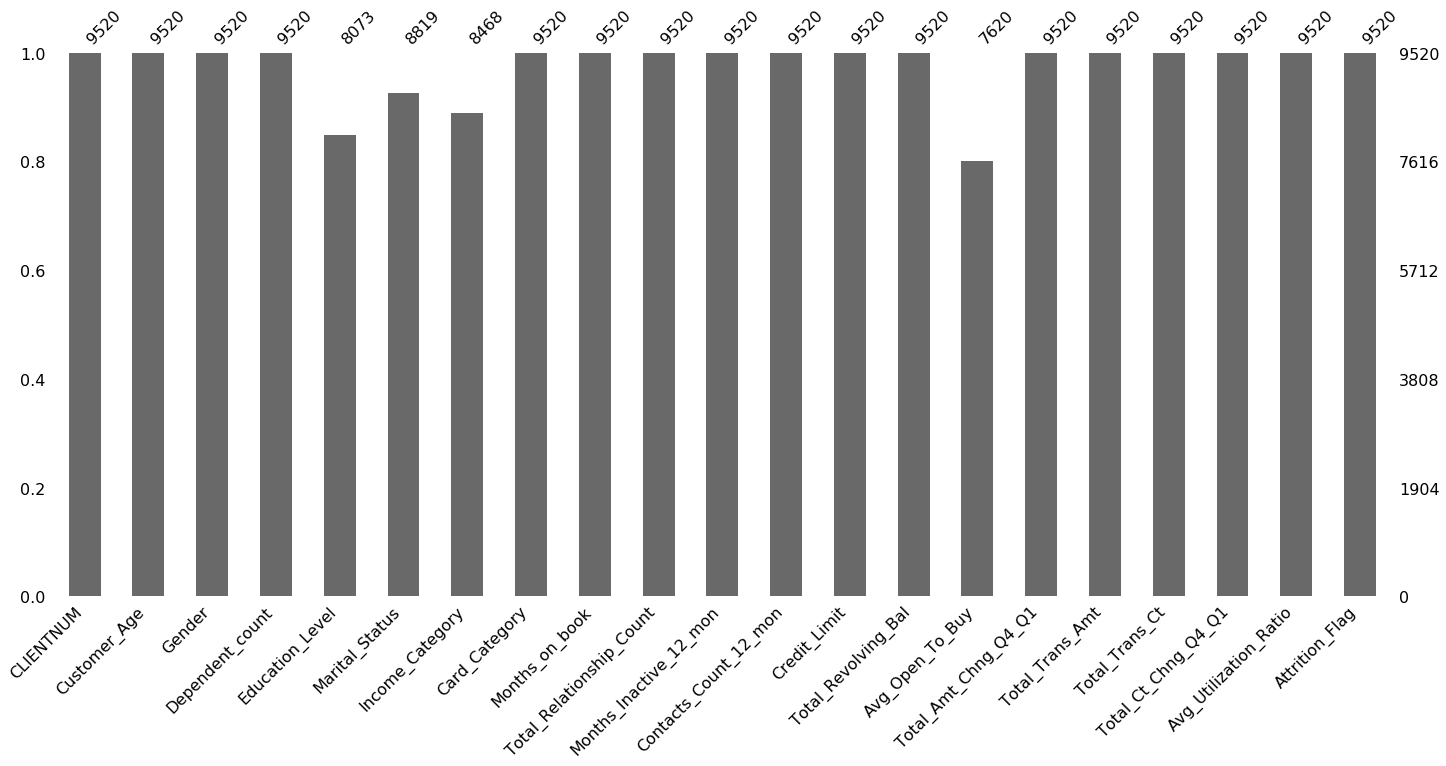

In [18]:
msno.bar(churn_data_with_id_replace_unknowns)

From the above plots, if we are to treat `Unknown` entries as "missing", we can see there are `~700` `Unknown` entries for `Marital Status`, `~1000` for `Income Category` and `~1500` for `Education Level`. There are also around `20%` of missing entries for the `Avg_Open_To_Buy` variable as we have seen earlier.

Looking at the missingness matrix above, we don't find there is a clear correlation bewteen the missing values in `[Education_Level, Marital_Status, Income_Category, Avg_Open_To_Buy]`. We may therefore assume these missing/unknown entries are likely to be missing completely at random.

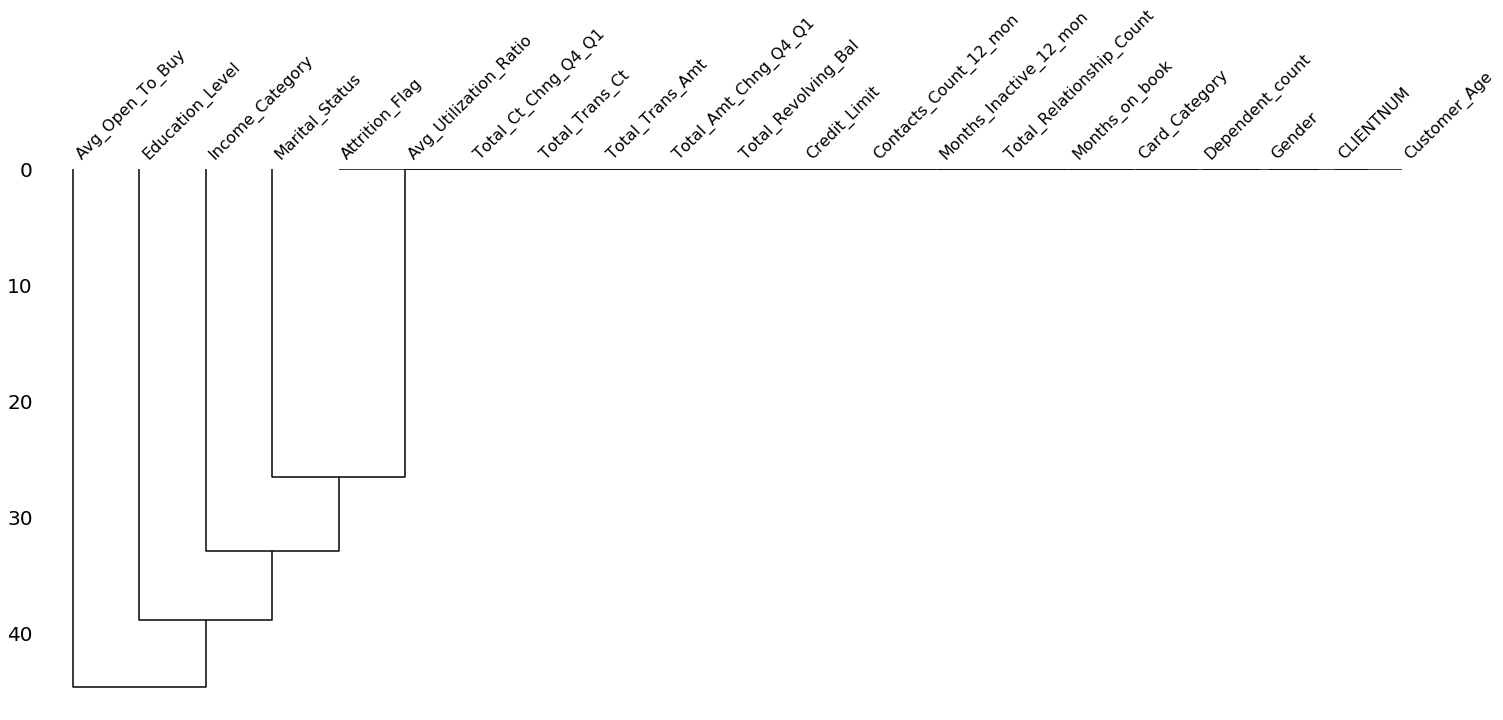

In [19]:
# dendrogram
msno.dendrogram(churn_data_with_id_replace_unknowns)

In [20]:
# missing entries correlation matrix
categories_with_missing = [
    'Education_Level',
    'Marital_Status',
    'Income_Category',
    'Avg_Open_To_Buy'
]
missing_correlation = churn_data_with_id_replace_unknowns[
    categories_with_missing
].isnull().corr()
missing_correlation

Education_Level  Marital_Status  Income_Category  \
Education_Level         1.000000       -0.000615        -0.017638   
Marital_Status         -0.000615        1.000000        -0.000595   
Income_Category        -0.017638       -0.000595         1.000000   
Avg_Open_To_Buy         0.005276        0.008145         0.002550   

                 Avg_Open_To_Buy  
Education_Level         0.005276  
Marital_Status          0.008145  
Income_Category         0.002550  
Avg_Open_To_Buy         1.000000

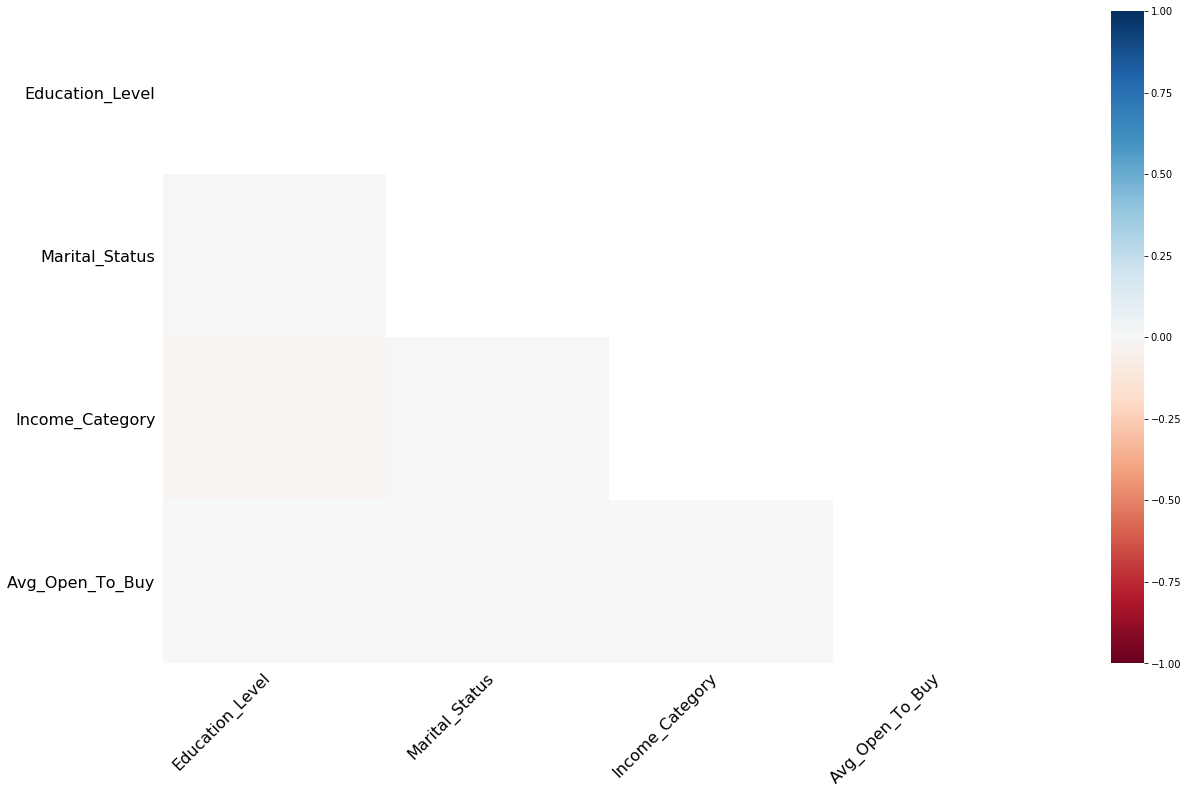

In [21]:
# missingness heatmap
msno.heatmap(churn_data_with_id_replace_unknowns)
plt.show()

Looking at the above missingness correlation matrix and corresponding heatmap, we can once again confirm these missing/unknown entries in the `[Education_Level, Marital_Status, Income_Category, Avg_Open_To_Buy]` variables are not at all correlated linearly and very likely to be missing completely at random.

# Inspecting individual feature column

Next, we perform a simple exploratory analysis on each individual feature columns separately, e.g. distributions for each categories for categorical data. Missing entries are excluded in the analysis. We will also drop the customer ID column as the IDs are just unique identifier of a customer and are unlikely to be useful in the analysis.

In [22]:
import matplotlib.pyplot as plt

# Common functions for plotting number of counts/% of counts 
# for each labels of a particular categorical variable

def hbar_count_plot(
    data: pd.core.frame.DataFrame,
    column: str,
    ylabel: str,
    xlabel: str = 'counts',
    sort_label: bool = False 
):
    """
    Return a horizontal barplot of value counts 
    of differnt labels for a categorical variable
    
    Parameters
    ----------
    data
        dataframe containing the data to plot for
    column
        the (categorical) column
    ylabel
        y-axis label
    xlabel
        x-xais label
    sort_label
        If True, sort the counts results by the categorical labels
        
    Returns
    -------
    fig
        a horizontal value counts barplot
    
    """
    
    counts = data[column].value_counts()
    if sort_label:
        counts.sort_index(inplace=True)
    
    fig = counts.plot.barh(y=ylabel)
    fig.set_ylabel(ylabel)
    fig.set_xlabel(xlabel)
    fig.set_title(f'Number of counts per {ylabel} labels')
    return fig

In [23]:
def hbar_percent_count_plot(
    data: pd.core.frame.DataFrame,
    column: str,
    xlabel: str = '%',
    sort_label: bool = False 
):
    """
    Return a horizontal barplot of % counts 
    of differnt labels for a categorical variable
    
    Parameters
    ----------
    data
        dataframe containing the data to plot for
    column
        the (categorical) column

    xlabel
        x-xais label
    sort_label
        If True, sort the counts results by the categorical labels
    
    """
    
    matplotlib.rc_file_defaults()
    %matplotlib inline
    
    percent_df = 100 * data[column].value_counts(normalize=True)
    percent_df.index.name = column
    percent_df.name = '%'
    percent_df = percent_df.reset_index()
    
    if sort_label:
        percent_df = percent_df.sort_values(column)
        
    scores = []
    plots = []
    sum_of_percent = 0
    for i in range(len(percent_df)):
        percent = percent_df.iloc[i, :]['%']
        scores.append(percent_df.iloc[i, :][column])
        plots.append(plt.barh(y=column, width=percent, left=sum_of_percent))
        sum_of_percent = sum_of_percent + float(percent)

    plt.title(f'% of customer per {column}')
    plt.legend(plots, scores)
    plt.xlabel(xlabel)
    plt.show()

$\color{blue} {\text{categorical data}}$

Here let us study the statistics of the categorical/non-numerical variables in this customer dataset first, i.e. `[Gender, Education Level, Marital Status, Income_Category, Card Category, Attrition_Flag]`. 

Here in this section we will treat the `Unknown` entries as a unique class label instead of treating them as missing.

$\color{blue} {\text{A) Gender}}$

In [24]:
# entries count of each gender
churn_data_with_id['Gender'].value_counts()

F    5032
M    4488
Name: Gender, dtype: int64

In [25]:
# % count of each gender
100 * churn_data_with_id['Gender'].value_counts(normalize=True)

F    52.857143
M    47.142857
Name: Gender, dtype: float64

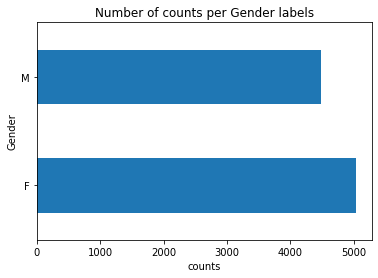

In [26]:
hbar_count_plot(churn_data_with_id, 'Gender', 'Gender')

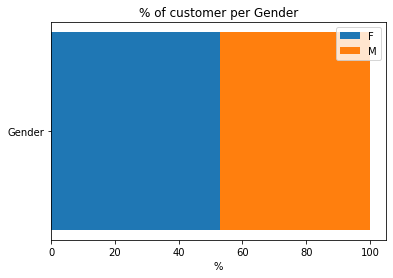

In [27]:
hbar_percent_count_plot(churn_data_with_id, 'Gender')

From the above, we can see the customers in this dataset are distributed fairly evenly between female and male, with slightly more female customers as compared to male `(53% vs 47%)`.

$\color{blue} {\text{B) Education Level}}$

In [28]:
# entries count of each education level
churn_data_with_id['Education_Level'].value_counts()

Graduate         2926
High School      1901
Unknown          1447
Uneducated       1393
College           949
Post-Graduate     483
Doctorate         421
Name: Education_Level, dtype: int64

In [29]:
# % count of each education level
100 * churn_data_with_id['Education_Level'].value_counts(normalize=True)

Graduate         30.735294
High School      19.968487
Unknown          15.199580
Uneducated       14.632353
College           9.968487
Post-Graduate     5.073529
Doctorate         4.422269
Name: Education_Level, dtype: float64

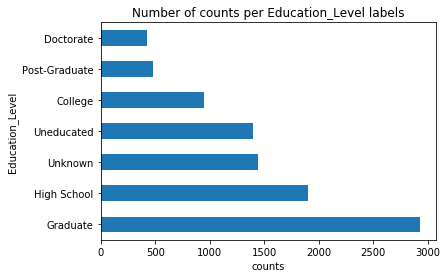

In [30]:
hbar_count_plot(churn_data_with_id, 'Education_Level', 'Education_Level')

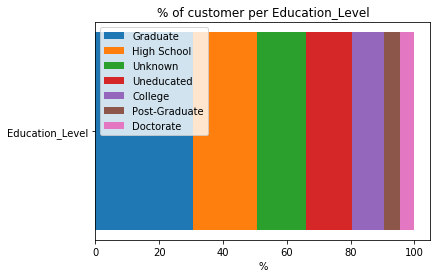

In [31]:
hbar_percent_count_plot(churn_data_with_id, 'Education_Level')

From the above, we can see the majority (`~50%`) of the customers are either of `Graduate` or 
`High School` education level. Specifically, there are around `~30%` of the customers are of the `Graduate` education level class, `~20%` are of `High School` and `~15%` are classified as `Uneducated`. 

There are also `~10%` of customers whose education level are classified as `College`. On the other hand, only a handful (`~4-5%`) of customers have `Post-Graduate` or `Doctorate` qualification.

There are also around `15%` of the customers are of `Unknown` education level in this dataset.

$\color{blue} {\text{C) Marital Status}}$

In [32]:
# entries count of each marital status
churn_data_with_id['Marital_Status'].value_counts()

Married     4414
Single      3700
Divorced     705
Unknown      701
Name: Marital_Status, dtype: int64

In [33]:
# % count of each marital status
100 * churn_data_with_id['Marital_Status'].value_counts(normalize=True)

Married     46.365546
Single      38.865546
Divorced     7.405462
Unknown      7.363445
Name: Marital_Status, dtype: float64

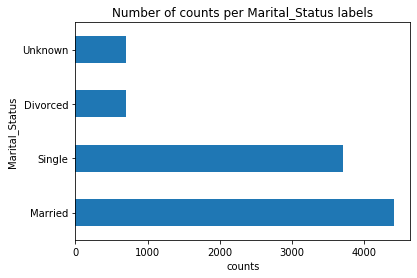

In [34]:
hbar_count_plot(churn_data_with_id, 'Marital_Status', 'Marital_Status')

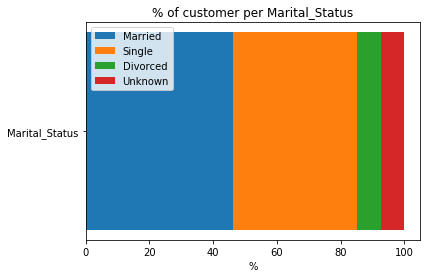

In [35]:
hbar_percent_count_plot(churn_data_with_id, 'Marital_Status')

From the above, we can see the majority (`~85%`) of the customers are `Married` or 
`Single`. Specifically, there are around `~46%` of the customers are `Married`, whereas `~39%` are `Single`. 

For the remaining customers, they are either of `Divorced` or `Unknown` marital status, both accounts for `~7%` (i.e. ~700) customers in this dataset.

$\color{blue} {\text{D) Income Category}}$

In [36]:
# entries count of each income category
churn_data_with_id['Income_Category'].value_counts()

Less than $40K    3342
$40K - $60K       1680
$80K - $120K      1433
$60K - $80K       1321
Unknown           1052
$120K +            692
Name: Income_Category, dtype: int64

In [37]:
# % count of each income category
100 * churn_data_with_id['Income_Category'].value_counts(normalize=True)

Less than $40K    35.105042
$40K - $60K       17.647059
$80K - $120K      15.052521
$60K - $80K       13.876050
Unknown           11.050420
$120K +            7.268908
Name: Income_Category, dtype: float64

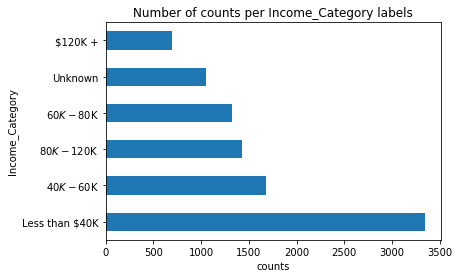

In [38]:
hbar_count_plot(churn_data_with_id, 'Income_Category', 'Income_Category')

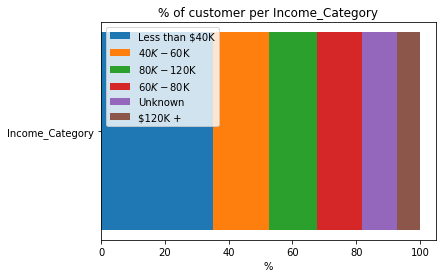

In [39]:
hbar_percent_count_plot(churn_data_with_id, 'Income_Category')

From the above, we can see there are around `~35%` of the customers with an income level of `Less than $40K`. For the income categories `[$40K - $60K, $60K - $80K, $80K - $120K]`, they account for around `14-18%` of the total each.

Only `7%` of the customers having an income level `$120K +` in this dataset. There are also around `11%` of customers with an `Unknown` income level.

$\color{blue} {\text{E) Card Category}}$

In [40]:
# entries count of each card category
churn_data_with_id['Card_Category'].value_counts()

Blue        8872
Silver       522
Gold         107
Platinum      19
Name: Card_Category, dtype: int64

In [41]:
# % count of each card category
100 * churn_data_with_id['Card_Category'].value_counts(normalize=True)

Blue        93.193277
Silver       5.483193
Gold         1.123950
Platinum     0.199580
Name: Card_Category, dtype: float64

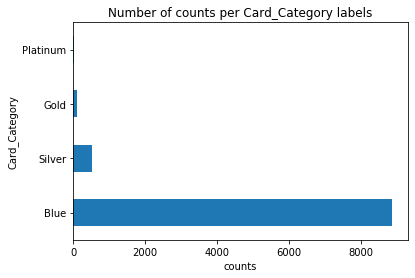

In [42]:
hbar_count_plot(churn_data_with_id, 'Card_Category', 'Card_Category')

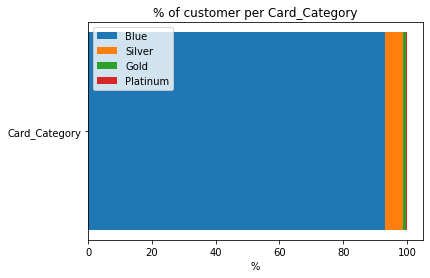

In [43]:
hbar_percent_count_plot(churn_data_with_id, 'Card_Category')

From the above, we can see almost all of the customers (`~93%`) are of the `Blue` card category.

For the remaining card categories, `Silver` accounts for around `5%` of the total customers, `Gold` ccounts for around `1%`, whereas the `Platinum` class only accounts for `0.2%` of the total customers in this dataset.

$\color{blue} {\text{F) Attrition_Flag}}$

In [44]:
# entries count of each attrition flag
churn_data_with_id['Attrition_Flag'].value_counts()

Existing Customer    7987
Attrited Customer    1533
Name: Attrition_Flag, dtype: int64

In [45]:
# % count of each attrition flag
100 * churn_data_with_id['Attrition_Flag'].value_counts(normalize=True)

Existing Customer    83.897059
Attrited Customer    16.102941
Name: Attrition_Flag, dtype: float64

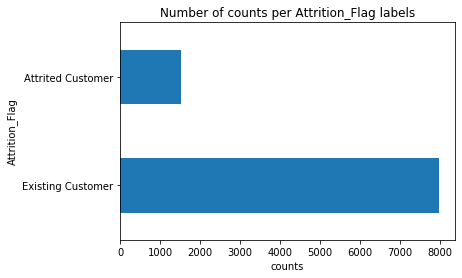

In [46]:
hbar_count_plot(churn_data_with_id, 'Attrition_Flag', 'Attrition_Flag')

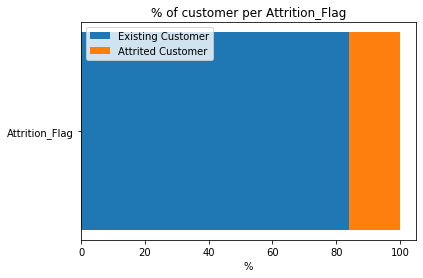

In [47]:
hbar_percent_count_plot(churn_data_with_id, 'Attrition_Flag')

From the above, $\color{red} {\text{we can see this dataset is imbalanced in terms of the churn target variable `Attrition_Flag`}}$, with a majority of `~83%` of customers are existing (non-churned) customers and only `~16%` are churned. 

One would need to take this into account when using this dataset to build models to predict whether a customer is likely to be churn or not.

$\color{blue} {\text{Numerical data}}$

Next we investigate the statistics of the numerical feature variables, i.e. `[Customer_Age, Dependent_count]` for demographic variables, and all the product variables except `Card_Category`.

In [48]:
# function to plot the numerical variable distribution
from typing import Optional

def plot_numerical_feature_distribution(
    data: pd.core.frame.DataFrame,
    column: str,
    number_of_bins: Optional[int] = None,
    xlabel: Optional[str] = None,
    plot_kde: bool = True
):
    """
    Plot the distribution of the input numerical
    feature variable in the given dataset
    
    Params
    ------
    data
        the dataset in pandas dataframe
    column
        the numerical feature variable name
    number_of_bins
        Optional, number of bins in the distribution plot.
        Default = None
    xlabel
        Optional. label of the x-axis. If none, use 
        the column name instead.
        Default = None
    plot_kde
        If True, add a KDE curve to the distribution
        plot. Default = True
    
    """
    
    sns.set()
    
    if number_of_bins is not None:
        sns.displot(data[column], kde=plot_kde, bins=number_of_bins)
    else:
        sns.displot(data[column], kde=plot_kde)
    
    # use the column variable name if xlabel is not given
    if xlabel is None:
        xlabel = column
    plt.xlabel(xlabel)
    plt.show()

$\color{blue} {\text{A) Customer Age}}$

In [49]:
churn_data_with_id['Customer_Age'].describe()

count    9520.000000
mean       46.334874
std         8.029102
min        26.000000
25%        41.000000
50%        46.000000
75%        52.000000
max        73.000000
Name: Customer_Age, dtype: float64

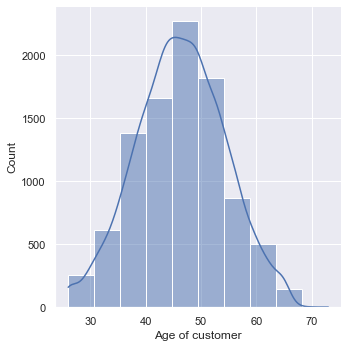

In [50]:
plot_numerical_feature_distribution(
    churn_data_with_id, 'Customer_Age', 
    number_of_bins=10,
    xlabel='Age of customer', 
    plot_kde=True
)

From the above, we can see the customer age very much follows a bell-shaped distribution centred around `45` year of age in this dataset, though they appear to be slightly more customers in both tail ends (around `25-30` and `65-70`) as compared to a perfect bell-shaped distribution.

$\color{blue} {\text{B) Dependent count}}$

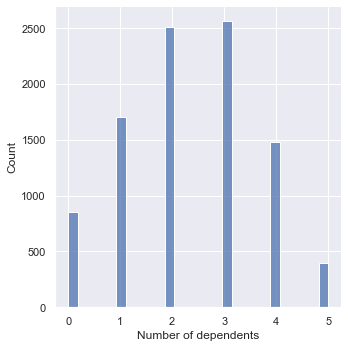

In [51]:
plot_numerical_feature_distribution(
    churn_data_with_id, 'Dependent_count', 
    xlabel='Number of dependents', 
    plot_kde=False
)

In [52]:
# % count of each number of dependents
100 * churn_data_with_id['Dependent_count'].value_counts(normalize=True)

3.0    26.932773
2.0    26.376050
1.0    17.941176
4.0    15.577731
0.0     8.970588
5.0     4.201681
Name: Dependent_count, dtype: float64

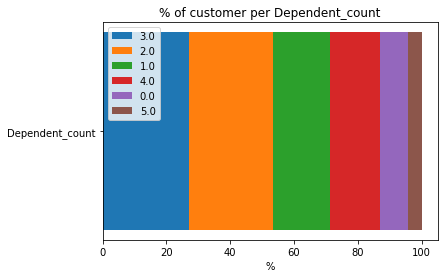

In [53]:
hbar_percent_count_plot(churn_data_with_id, 'Dependent_count')

From the above, we can see majority of the customers (`~53%`) have either 2 or 3 number of dependents. Specifically, `~27%` have 3 and `~26%` have 2.

For the remaining customers, `~18%` have only 1 dependent and `~16%` have 4. There are also around `~9%` of the customers who do not have any dependent and around `4%` have 5 dependents.

$\color{blue} {\text{C) Months on book}}$

In [54]:
churn_data_with_id['Months_on_book'].describe()

count    9520.000000
mean       35.933613
std         7.977988
min        13.000000
25%        31.000000
50%        36.000000
75%        40.000000
max        56.000000
Name: Months_on_book, dtype: float64

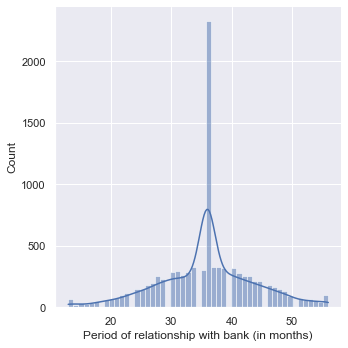

In [55]:
plot_numerical_feature_distribution(
    churn_data_with_id, 'Months_on_book', 
    xlabel='Period of relationship with bank (in months)'
)

From the above, we can see the customer's period of relationship with bank (in months) has a very flat distribution except a very sharp peak around `36` months. 

$\color{red} {\text{There are more than `20%` of customers having a `36` month or 3-year relationship with the bank.}}$

This strongly suggests there is likely to be some contract terms or policy reasons behind this observation, e.g. the minimum contract terms.

$\color{blue} {\text{D) Total Relationship Count}}$

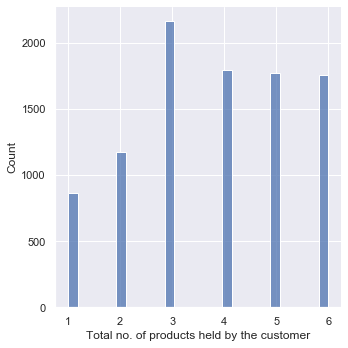

In [56]:
plot_numerical_feature_distribution(
    churn_data_with_id, 
    'Total_Relationship_Count', 
    xlabel='Total no. of products held by the customer',
    plot_kde=False
)

In [57]:
# % count of each total no. of products held by the customer
100 * churn_data_with_id['Total_Relationship_Count'].value_counts(normalize=True)

3.0    22.720588
4.0    18.834034
5.0    18.592437
6.0    18.445378
2.0    12.300420
1.0     9.107143
Name: Total_Relationship_Count, dtype: float64

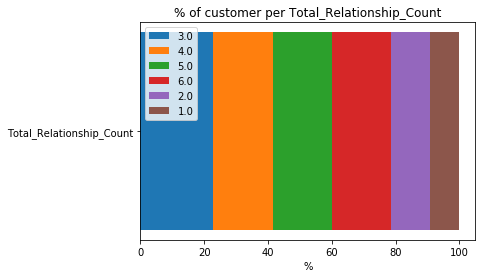

In [58]:
hbar_percent_count_plot(
    churn_data_with_id, 
    'Total_Relationship_Count'
)

From the above, we can see majority (`~80%`) of the customers hold 3-6 products, with around `23%` having 3. For the remaining customers, `~12%` hold 2 products and `~9%` have only 1.

$\color{blue} {\text{E) Months Inactive last 12 months}}$

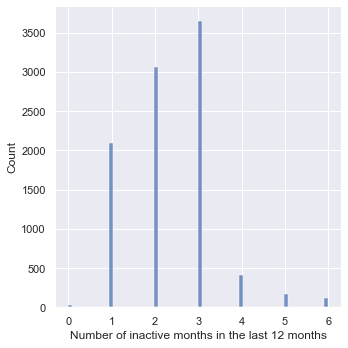

In [59]:
plot_numerical_feature_distribution(
    churn_data_with_id, 
    'Months_Inactive_12_mon', 
    xlabel='Number of inactive months in the last 12 months',
    plot_kde=False
)

In [60]:
# % count of each number of dependents
100 * churn_data_with_id['Months_Inactive_12_mon'].value_counts(normalize=True)

3.0    38.340336
2.0    32.132353
1.0    21.964286
4.0     4.275210
5.0     1.743697
6.0     1.250000
0.0     0.294118
Name: Months_Inactive_12_mon, dtype: float64

From the above, we can see majority (`~92%`) of the customers have been inactive for either 1-3 months in the last 12 months, with `~38%` being inactive for 3 months and `~32%` for 2 months.

There are only a handful of customers (`~7%`) being inactive for 4-6 months, whereas only `0.3%` of customers have not been inactive at all over the last 12 months.

$\color{blue} {\text{F) Contacts Count last 12 months}}$

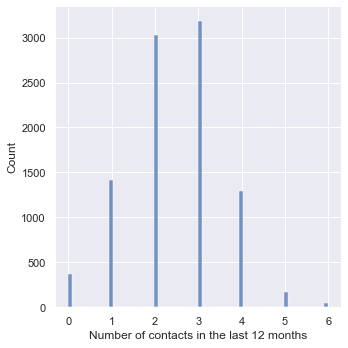

In [61]:
plot_numerical_feature_distribution(
    churn_data_with_id, 
    'Contacts_Count_12_mon', 
    xlabel='Number of contacts in the last 12 months',
    plot_kde=False
)

In [62]:
# % count of each number of dependents
100 * churn_data_with_id['Contacts_Count_12_mon'].value_counts(normalize=True)

3.0    33.445378
2.0    31.817227
1.0    14.884454
4.0    13.592437
0.0     3.939076
5.0     1.764706
6.0     0.556723
Name: Contacts_Count_12_mon, dtype: float64

From the above, we can see majority (`~65%`) of the customers have 2-3 number of contacts over the last 12 months, with `33%` having 3 and `32%` having 2. There are around `15%` and `14%` of customers having 1 and 4 number of contacts respectively.

On the other hand, only a handful of customers (`1-4%`) each having either 0, 5 or 6 number of contacts over the last 12 months.

$\color{blue} {\text{G) Credit Limit}}$

In [63]:
churn_data_with_id['Credit_Limit'].describe()

count     9520.000000
mean      8604.085389
std       9056.394383
min       1438.300000
25%       2550.000000
50%       4539.500000
75%      10998.500000
max      34516.000000
Name: Credit_Limit, dtype: float64

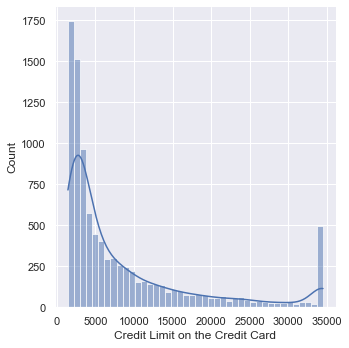

In [64]:
plot_numerical_feature_distribution(
    churn_data_with_id, 
    'Credit_Limit', 
    xlabel='Credit Limit on the Credit Card'
)

From the above, we can see the credit limit follows an exponential-like distribution, with a significant number of customers having a credit limit `<$2500`. There are however a significant deviation towards the upper end tail, with around `~%5` having a credit limit `~$35000`.

$\color{blue} {\text{H) Total Revolving Balance}}$

In credit card terms, a revolving balance is the portion of credit card spending that goes unpaid at the end of a billing cycle.

$\color{green} {\text{Question one may ask: total as of what? over the entire credit card history?}}$

In [65]:
churn_data_with_id['Total_Revolving_Bal'].describe()

count    9520.000000
mean     1162.837605
std       813.249598
min         0.000000
25%       396.750000
50%      1278.000000
75%      1782.000000
max      2517.000000
Name: Total_Revolving_Bal, dtype: float64

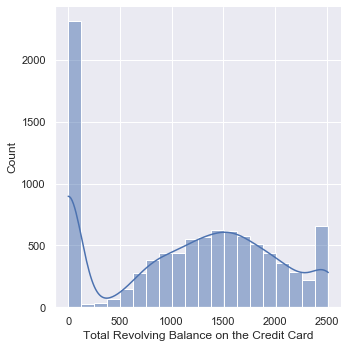

In [66]:
plot_numerical_feature_distribution(
    churn_data_with_id, 
    'Total_Revolving_Bal', 
    xlabel='Total Revolving Balance on the Credit Card'
)

From the above, we can see the total revolving balance follows more or less a bell-shaped distribution except both tail ends, with a significant number of customers (`>20%`) having a total revolving balance `< $125` and (`>5%`) having a total revolving balance of around $2400-2500. 

$\color{blue} {\text{I) Average Open To Buy (last 12 months)}}$

Open To Buy on credit card is defined as the difference between the credit limit assigned to a cardholder account and the present balance on the account. Here we have the average open-to-buy over the last 12 months.

First we let us go back to check if there are no customers whose its average open-to-buy exceeds his/her credit card limit. We can see from below that there isn't any in the dataset.

In [67]:
# check ratio of average open-to-buy / credit limit
average_open_to_buy_over_credit_limit = (
    churn_data_with_id['Avg_Open_To_Buy'] / churn_data_with_id['Credit_Limit'] 
)
average_open_to_buy_over_credit_limit.describe()

count    7620.000000
mean        0.723408
std         0.276913
min         0.001232
25%         0.494303
50%         0.822031
75%         0.976851
max         1.000000
dtype: float64

In [68]:
# summary stats of average open-to-buy 
churn_data_with_id['Avg_Open_To_Buy'].describe()

count     7620.000000
mean      7470.433255
std       9084.029874
min          3.000000
25%       1295.000000
50%       3505.000000
75%       9949.250000
max      34516.000000
Name: Avg_Open_To_Buy, dtype: float64

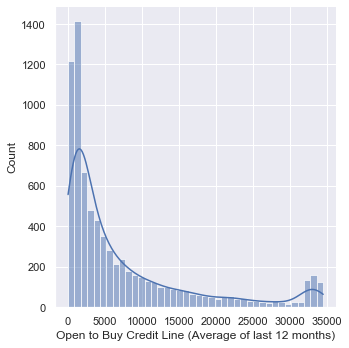

In [69]:
plot_numerical_feature_distribution(
    churn_data_with_id, 
    'Avg_Open_To_Buy', 
    xlabel='Open to Buy Credit Line (Average of last 12 months)'
)

From the above, we can see the average open-to-buy over the last 12 months follows more or less a Poission-like distribution except on the upper tail, with majority of customers having the average open-to-buy `< $5000` over the last 12 months. 

There are some significant deviations at the upper tail around `~$31000-35000`.

$\color{blue} {\text{J) Change in Transaction Amount (Q4 over Q1)}}$

This is defined as the total transaction amount in Q4 over that of Q1. A ratio of `>1` means there is an increase in transaction amount, whereas anything less than 1 means a decrease.

In [70]:
churn_data_with_id['Total_Amt_Chng_Q4_Q1'].describe()

count    9520.000000
mean        0.760347
std         0.220522
min         0.000000
25%         0.631000
50%         0.737000
75%         0.860000
max         3.397000
Name: Total_Amt_Chng_Q4_Q1, dtype: float64

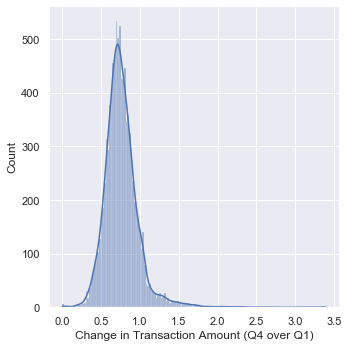

In [71]:
plot_numerical_feature_distribution(
    churn_data_with_id, 
    'Total_Amt_Chng_Q4_Q1', 
    xlabel='Change in Transaction Amount (Q4 over Q1)'
)

From the above, we can see the change in transaction amount (Q4 over Q1) follows more or less a bell-shaped distribution with a majority centred around the ratio `0.7`. We can see majority of the customers (>70%) have a decease in transaction amount in Q4 as compared to that of Q1.

$\color{green} {\text{Question one may ask: seasonal trends reason behind this observation?}}$

$\color{blue} {\text{K) Total Transaction Amount (Last 12 months)}}$

In [72]:
churn_data_with_id['Total_Trans_Amt'].describe()

count     9520.000000
mean      4390.698529
std       3383.304617
min        510.000000
25%       2153.000000
50%       3889.000000
75%       4738.000000
max      18484.000000
Name: Total_Trans_Amt, dtype: float64

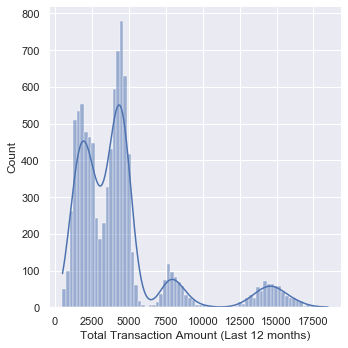

In [73]:
plot_numerical_feature_distribution(
    churn_data_with_id, 
    'Total_Trans_Amt', 
    xlabel='Total Transaction Amount (Last 12 months)'
)

From the above, we can see the total transaction Amount over the last 12 months follows a multiple peaks distribution, with the peaks centred around `$2300`, `$4800`, `$7500` and `$13000`. 

This suggests there could be 4 distinct customer behaviour in this dataset.

$\color{blue} {\text{L) Total Transaction Count (Last 12 months)}}$

In [74]:
churn_data_with_id['Total_Trans_Ct'].describe()

count    9520.000000
mean       64.745483
std        23.427900
min        10.000000
25%        45.000000
50%        67.000000
75%        80.000000
max       139.000000
Name: Total_Trans_Ct, dtype: float64

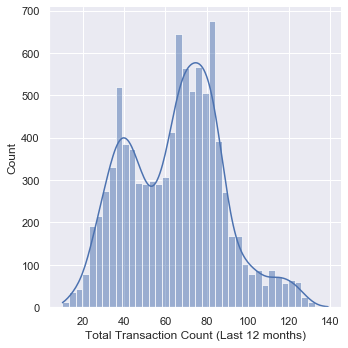

In [75]:
plot_numerical_feature_distribution(
    churn_data_with_id, 
    'Total_Trans_Ct', 
    xlabel='Total Transaction Count (Last 12 months)'
)

From the above, we can see the total transaction count over the last 12 months also follows a multiple peaks distribution, with two distinct peaks centred around `40` and `70`.

This again suggests there could be distinct customer behaviour in this dataset.

$\color{blue} {\text{M) Change in Transaction Count (Q4 over Q1)}}$

This is defined as the total transaction count in Q4 over that of Q1. A ratio of `>1` means there is an increase in transaction count, whereas anything less than 1 means a decrease.

In [76]:
churn_data_with_id['Total_Ct_Chng_Q4_Q1'].describe()

count    9520.000000
mean        0.711424
std         0.238675
min         0.000000
25%         0.581000
50%         0.700000
75%         0.818000
max         3.714000
Name: Total_Ct_Chng_Q4_Q1, dtype: float64

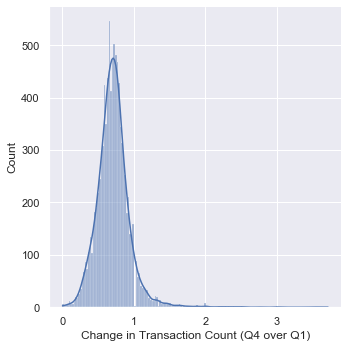

In [77]:
plot_numerical_feature_distribution(
    churn_data_with_id, 
    'Total_Ct_Chng_Q4_Q1', 
    xlabel='Change in Transaction Count (Q4 over Q1)'
)

From the above, we can see the change in transaction count (Q4 over Q1) follows more or less a bell-shaped distribution with a majority centred around the ratio `0.7`, as similar to that of change in transaction amount. Again we can see majority of the customers (>70%) have a decease in transaction count in Q4 as compared to that of Q1.

$\color{green} {\text{Again question one may ask: seasonal trends reason behind this observation?}}$

$\color{blue} {\text{N) Average Card Utilization Ratio}}$

The credit utilisation ratio is the percentage of the total available credit that is currently being utilised. 

Before studying its statistics and distribution, we would like to investigate if this variable are related to the `Avg_Open_To_Buy` and `Credit_Limit`. In particularly, we would like to find out if this average utilisation ratio is in fact equals to `average present balance (last 12 months) / credit limit`.

Note that we can use `average present balance (last 12 months) / credit limit = 1 - average open-to-buy (last 12 months) / credit limit` here to work out the average present balance ratio.

$\color{green} {\text{Question: average as of what? over the entire credit card history?}}$

In [78]:
# average present balance (last 12 months) over credit limit
average_present_balance_over_credit_limit = 1 - average_open_to_buy_over_credit_limit

In [79]:
ratio_df = pd.DataFrame({})
ratio_df['average_present_balance_ratio'] = average_present_balance_over_credit_limit.apply(
    lambda x: round(x, 3)
)
ratio_df['average_open_to_buy_ratio'] = average_open_to_buy_over_credit_limit
ratio_df['average_utilisation_ratio'] = churn_data_with_id['Avg_Utilization_Ratio']

In [80]:
# difference between the computed average present balance ratio 
# and the given average card utilisation ratio
ratio_difference = (
    ratio_df['average_utilisation_ratio'] - ratio_df['average_present_balance_ratio']
)
ratio_difference.describe()

count    7.620000e+03
mean     1.312336e-07
std      1.145572e-05
min     -1.110223e-16
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e-03
dtype: float64

$\color{green} {\text{From the above, we can conclude the two ratios are the same.}}$
$\color{green} {\text{So the the utilisation ratio is given as average of last 12 months.}}$

In [81]:
churn_data_with_id['Avg_Utilization_Ratio'].describe()

count    9520.000000
mean        0.275465
std         0.275831
min         0.000000
25%         0.023000
50%         0.177000
75%         0.502250
max         0.999000
Name: Avg_Utilization_Ratio, dtype: float64

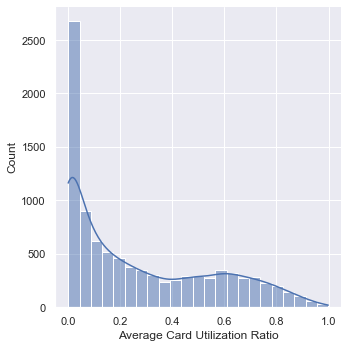

In [82]:
plot_numerical_feature_distribution(
    churn_data_with_id, 
    'Avg_Utilization_Ratio', 
    xlabel='Average Card Utilization Ratio'
)

From the above, we can see the average card utilization ratio follows an exponential-like distribution at the lower end, but then with an additional smaller and flatter peak centred around the ratio 0.6.

Given this average card utilization ratio is in fact highly related to the average open-to-buy and can be derived from it, `[Avg_Open_To_Buy, Avg_Utilization_Ratio]` are very likely to contain the same amount of (useful) information. 

There we may drop `Avg_Open_To_Buy` variable when we move to building predictive models on customer churn, especially since there are missing entries in it.

# Correlation of categorical variables with the Attrition_Flag

In [83]:
# text annotation function for the seaborn catplot
def annotate(data, **kws):
    """
    Function that add corresponding attrition type percentage 
    within the same categorical label annotation text in 
    the seaborn catplot
    
    Params
    ------
    data
        data within the same categorical label
    
    """

    total = len(data)
    ax = plt.gca()
    
    # add annotation for each attrition type patch
    for p in ax.patches:
        try:
            percent = round(100 * int(p.get_height()) / total, 1)
        except ValueError:
            percent = 0
            
        ax.text(
            p.get_x() + p.get_width()/2., p.get_height(), 
            f"{percent} %",
            fontsize=12, color='blue', ha='center', va='bottom'
        )

In [84]:
# churn percentage analysis function(s)
def get_churn_percent_within_categorical_label(
    categorical_col: str, 
    data: pd.core.frame.DataFrame
) -> pd.core.frame.DataFrame:
    """
    Function that returns the sample sizes and percentage of
    churn customers with the same labels of a particular 
    categorical variable

    Parameters
    ----------
    categorical_col
        The particular categorical feature variable of interest
    data
        The input dataframe containing the dataset.

    Returns
    -------
    churn_customers_df
        churn customer sample sizes and corresponding % per labels

    """
    
    churn_customers_df = pd.DataFrame(
        columns=[categorical_col, 'sample_size', 'churn percentage (%)']
    )
    
    # unique categorical labels
    churn_customers_df[categorical_col] = data[categorical_col].dropna().unique().tolist()
    
    # calculate churn customer sample sizes and percentages per labels
    percents = []
    sample_sizes = []
    for label in churn_customers_df[categorical_col]:
        customer_of_same_label = data[data[categorical_col]==label]
        total = len(customer_of_same_label)
        churn_totals = len(
            customer_of_same_label[
                customer_of_same_label['Attrition_Flag'] == 'Attrited Customer'
            ]
        )
        
        churn_customers_df.loc[
            churn_customers_df[categorical_col] == label, 'sample_size'
        ] = churn_totals
        churn_customers_df.loc[
            churn_customers_df[categorical_col] == label, 'churn percentage (%)'
        ] = 100 * churn_totals/total

    return churn_customers_df

$\color{blue} {\text{A) Gender}}$

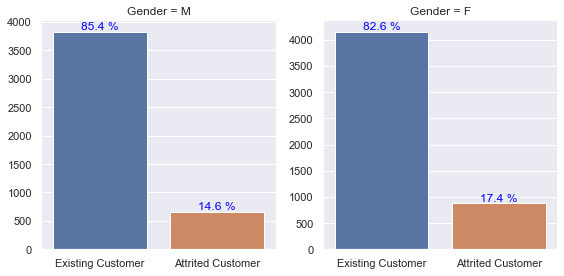

In [85]:
g = sns.catplot(
    x='Attrition_Flag', 
    col='Gender', 
    kind='count', 
    data=churn_data_with_id, 
    sharey=False,
    height=4
)
g.map_dataframe(annotate)
plt.show()

In [86]:
get_churn_percent_within_categorical_label('Gender', churn_data_with_id)

Gender sample_size churn percentage (%)
0      M         657               14.639
1      F         876              17.4086

From the above, we can see that there are slightly more churn customers (both in terms of percentage and counts), `17.4% (female) vs 14.6% (male)`, for female customers as compared to males.

$\color{blue} {\text{B) Education Level}}$

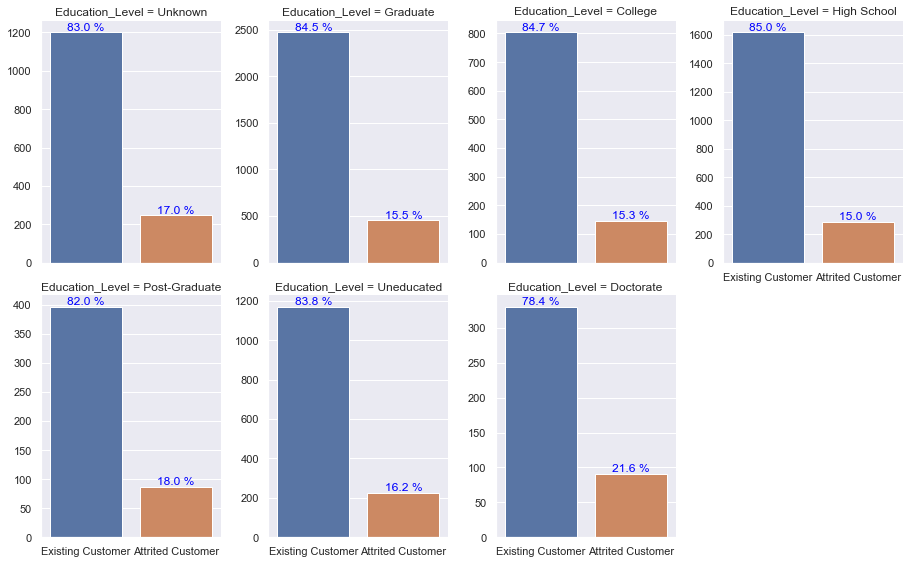

In [87]:
g = sns.catplot(
    x='Attrition_Flag', 
    col='Education_Level', 
    kind='count', 
    data=churn_data_with_id, 
    sharey=False,
    col_wrap=4,
    height=4,
    aspect=.8
)
g.map_dataframe(annotate)
plt.show()

In [88]:
get_churn_percent_within_categorical_label('Education_Level', churn_data_with_id)

Education_Level sample_size churn percentage (%)
0         Unknown         246              17.0007
1        Graduate         454              15.5161
2         College         145              15.2792
3     High School         285              14.9921
4   Post-Graduate          87              18.0124
5      Uneducated         225              16.1522
6       Doctorate          91              21.6152

From the above, we can see that `Post-Graduate (~18%)` and `Doctorate (~22%)` have a higher percentage of churn customers as compared to other education level classes. Yet only a handful of customers (4-5% of total customers in the dataset) are within these 2 classes and thus one should be cautious that this result may not be very representative.

For other education level classes, the percentages of churn customers are very much similar `(15-17%)`, with the `Unknown` class having a very slightly higher percentage (`17%`) as compared to the others `(15-16%)`.

$\color{blue} {\text{C) Marital Status}}$

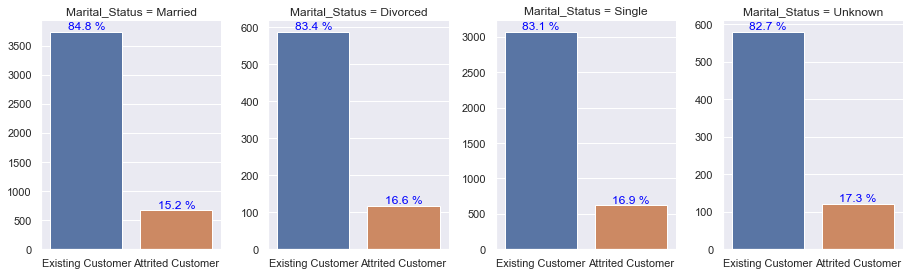

In [89]:
g = sns.catplot(
    x='Attrition_Flag', 
    col='Marital_Status', 
    kind='count', 
    data=churn_data_with_id, 
    sharey=False,
    col_wrap=4,
    height=4,
    aspect=.8
)
g.map_dataframe(annotate)
plt.show()

In [90]:
get_churn_percent_within_categorical_label('Marital_Status', churn_data_with_id)

Marital_Status sample_size churn percentage (%)
0        Married         670               15.179
1       Divorced         117              16.5957
2         Single         625              16.8919
3        Unknown         121              17.2611

From the above, we can see that the customer's marital status do not seem to have much of an impact on the churn percentage. 

The churn percentages are very much the same (`~15-17%`) across the 4 different marital status classes, with the `Unknown` class having a very slightly higher percentage (`17.3%`) as compared to the others `(15-16%)`. Though there aren't many customers (~7% of total customers in the dataset) are of the `Unknown` class and thus this may not be very representative.

$\color{blue} {\text{D) Income Category}}$

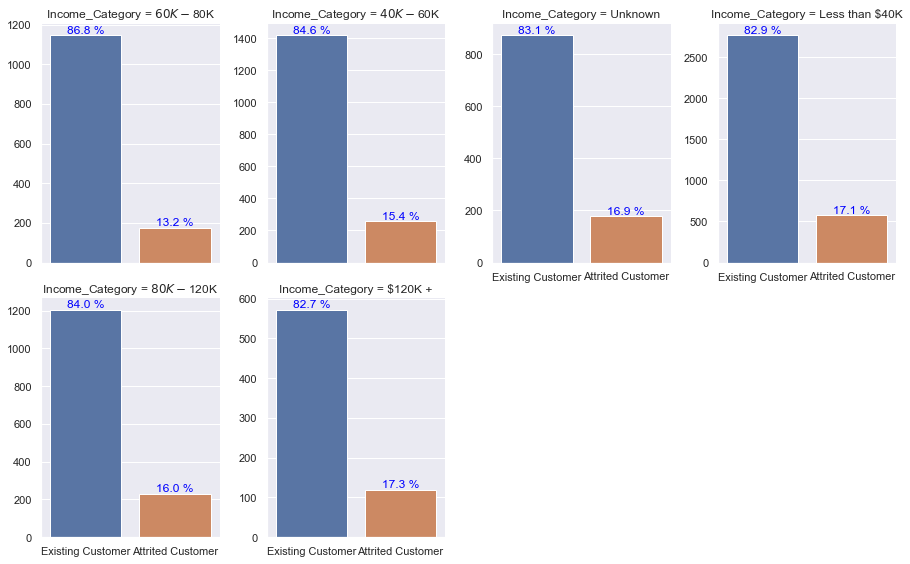

In [91]:
g = sns.catplot(
    x='Attrition_Flag', 
    col='Income_Category', 
    kind='count', 
    data=churn_data_with_id, 
    sharey=False,
    col_wrap=4,
    height=4,
    aspect=.8
)
g.map_dataframe(annotate)
plt.show()

In [92]:
get_churn_percent_within_categorical_label('Income_Category', churn_data_with_id)

Income_Category sample_size churn percentage (%)
0     $60K - $80K         174              13.1718
1     $40K - $60K         259              15.4167
2         Unknown         178              16.9202
3  Less than $40K         573              17.1454
4    $80K - $120K         229              15.9805
5         $120K +         120               17.341

From the above, we can see that the customer's income category do not seem to have too much of an impact on the churn percentage except the groups `$60-80K`, `Less than $40K` and `$120K +`.

For customer with an income of `$60-80K`, the churn percentage is lower (`~13%`), whereas for customers with an income of `Less than $40K` or `$120K +`, there appears to be a slightly higher churn percentage (`~17%`). One should note that though customers with `$120K +` income only accounts for 120 entries in the dataset and may not be too representative.

For the remaining income groups, the churn percentage is around (`~15-16%`), with the `Unknown` class having a very slightly higher churn percentage (`~17%`).

$\color{blue} {\text{E) Card Category}}$

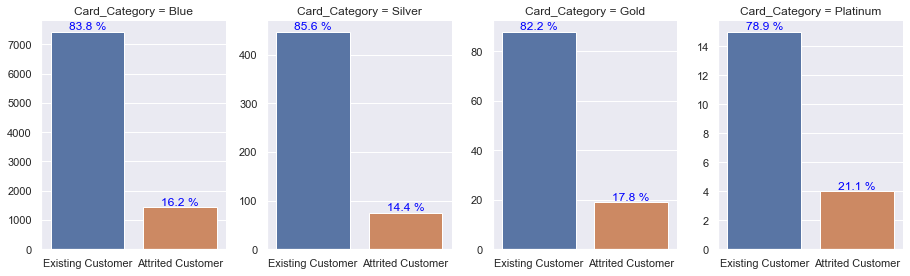

In [93]:
g = sns.catplot(
    x='Attrition_Flag', 
    col='Card_Category', 
    kind='count', 
    data=churn_data_with_id, 
    sharey=False,
    col_wrap=4,
    height=4,
    aspect=.8
)
g.map_dataframe(annotate)
plt.show()

In [94]:
get_churn_percent_within_categorical_label('Card_Category', churn_data_with_id)

Card_Category sample_size churn percentage (%)
0          Blue        1435              16.1745
1        Silver          75              14.3678
2          Gold          19               17.757
3      Platinum           4              21.0526

From the above, given majority of the customers are of the `Blue` card category, it is not surprising to see that the corresponding churn percentage is very much equal to that across the whole dataset (i.e. `~16%`).

For the other card categories, we can see `Gold` customers have a slightly higher churn percentage (i.e. `~17.8%`), whereas `Silver` customers have a slightly lower churn (i.e. `~14.4%`). `Platinum` customers have a much higher churn (i.e. `~21.1%`) on the other hand. However, one should note that there are only a handful of customers (`<75` each) for these card categories and thus this observation may not be very representative.

# Correlation of numerical variables with the Attrition_Flag

After investigating the correlation between the categorical variables and churn, we move to perform a similar analysis om the numerical variables in the following.

In [95]:
# functions to plot the numerical feature distributions per target classes
def plot_num_var_kde(
    data: pd.core.frame.DataFrame, 
    num_var: str,
    target: str = 'Attrition_Flag'
):
    """
    Function that returns kernel density estimate (KDE) plot of 
    the given numeric variable for each target labels

    Parameters
    ----------    
    data
        the customer dataset
    num_var
        The numeric feature variable 
    target
        the target variable

    """
    facet_plot = sns.FacetGrid(data, hue=target, aspect=4)
    facet_plot.map(sns.kdeplot, num_var, shade=True)
    facet_plot.set(xlim=(0, data[num_var].max()))
    facet_plot.add_legend()
    plt.title(f'KDE plot of {num_var} per {target} labels')
    plt.show()


def plot_num_var_vio_strip(
    data: pd.core.frame.DataFrame, 
    num_var: str,
    target: str = 'Attrition_Flag'
):
    """
    Function that returns violin and strip plots of the 
    given numeric variable for each target labels

    Parameters
    ----------    
    data
        the customer dataset
    num_var
        The numeric feature variable 
    target
        the target variable

    """
    fig, ax =  plt.subplots(ncols=2, sharey=True, figsize =(12,5))
    sns.violinplot(x=target, y=num_var, data=data, ax=ax[0])
    ax[0].set_title(f'Distribution of {num_var} \n per {target} class labels\n (violin plot)')
    sns.stripplot(x=target, y=num_var, data=data, alpha=0.2, jitter=True, ax=ax[1])
    
    target_labels = data[target].unique().tolist()
    ax[1].legend(target_labels)
    ax[1].set_title(f'Distribution of {num_var} \n per {target} class labels\n (strip plot)')
    plt.show()

$\color{blue} {\text{A) Customer Age}}$

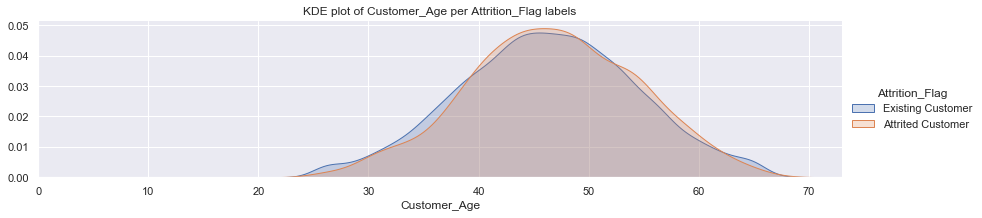

In [96]:
plot_num_var_kde(churn_data_with_id, 'Customer_Age')

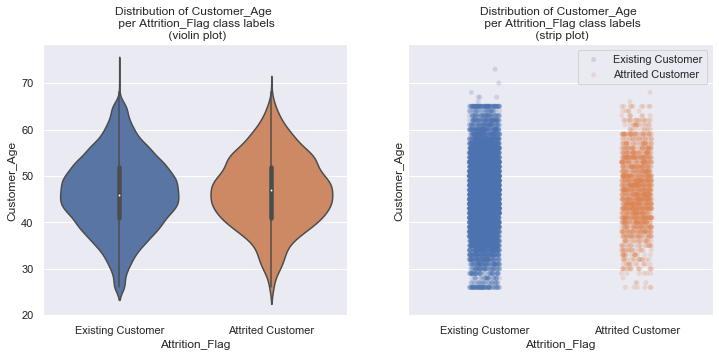

In [97]:
plot_num_var_vio_strip(churn_data_with_id, 'Customer_Age')

From the above, we can see the customer age distributions are very much the same for exisitng and churn customers. Therefore we can conclude customer age has little impact on the churn rate.

$\color{blue} {\text{B) Dependent count}}$

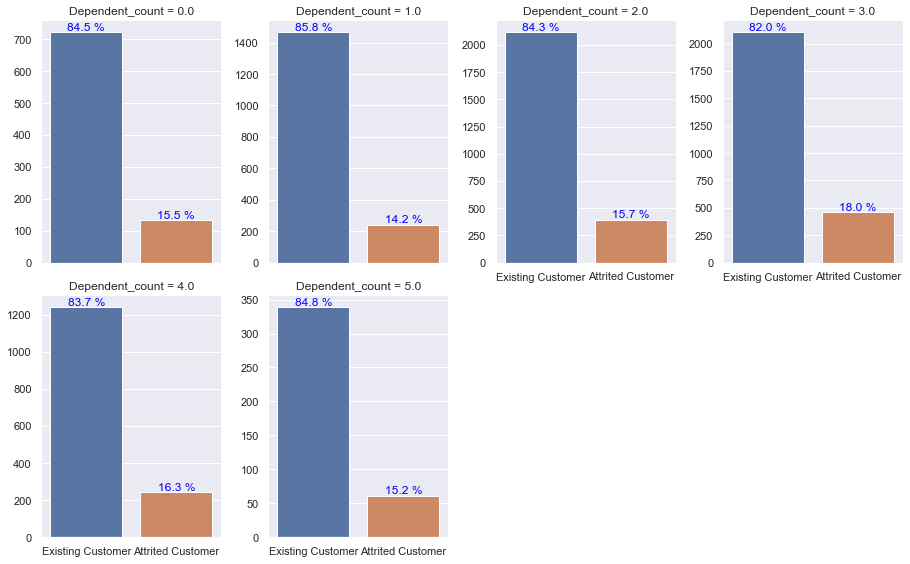

In [98]:
g = sns.catplot(
    x='Attrition_Flag', 
    col='Dependent_count', 
    kind='count', 
    data=churn_data_with_id, 
    sharey=False,
    col_wrap=4,
    height=4,
    aspect=.8
)
g.map_dataframe(annotate)
plt.show()

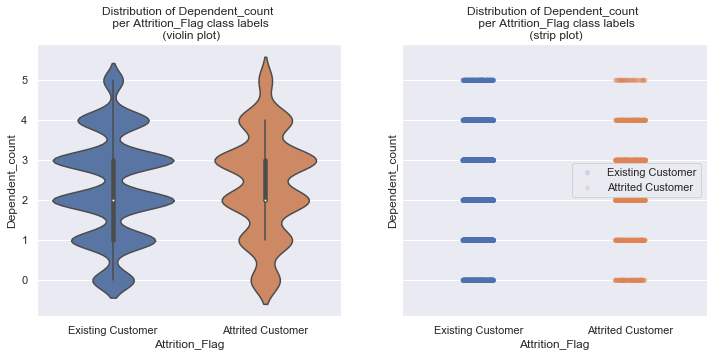

In [99]:
plot_num_var_vio_strip(churn_data_with_id, 'Dependent_count')

In [100]:
get_churn_percent_within_categorical_label('Dependent_count', churn_data_with_id)

Dependent_count  sample_size churn percentage (%)
0              3.0          461              17.9797
1              0.0          132              15.4567
2              1.0          242              14.1686
3              2.0          395              15.7308
4              4.0          242              16.3183
5              5.0           61                15.25

From the above, we can see the customers with 3 number of dependents have a slightly higher churn percentage (`~18%`), whereas those with only 1 dependent have a slightly lower churn percentage (`~14%`). 

Customers having other number of dependents have more or less the same churn percentage (`~15-16%`). One should note that there are only a handful of customers with 5 dependents and their corresponding churn percentage may not be very representative.

$\color{blue} {\text{C) Period of relationship with bank}}$

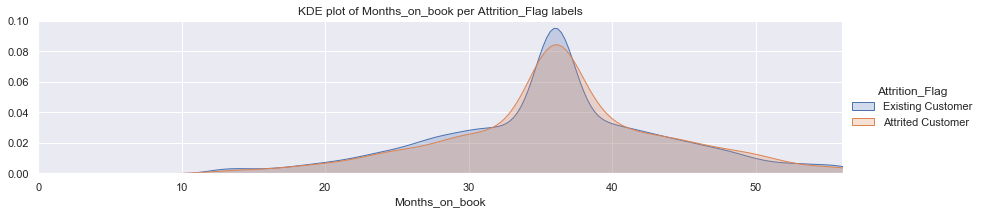

In [101]:
plot_num_var_kde(churn_data_with_id, 'Months_on_book')

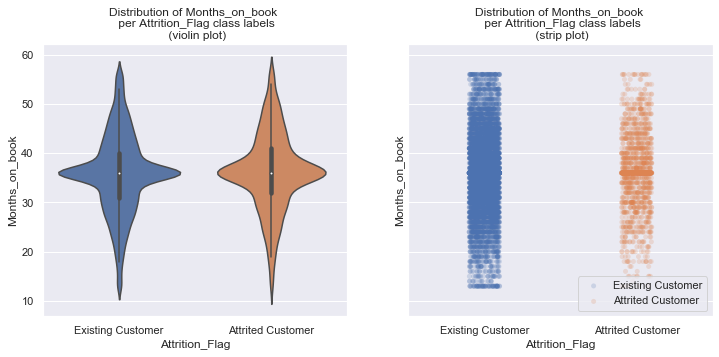

In [102]:
plot_num_var_vio_strip(churn_data_with_id, 'Months_on_book')

From the above, we can see both existing and churn customers have the period of relationship with bank (in months) peaked around `36 months` and their distributions look very much the same.

We therefore conclude the period of relationship with bank is likely to have little impact on the churn rate here. 

$\color{blue} {\text{D)  Total no. of products held by the customer}}$

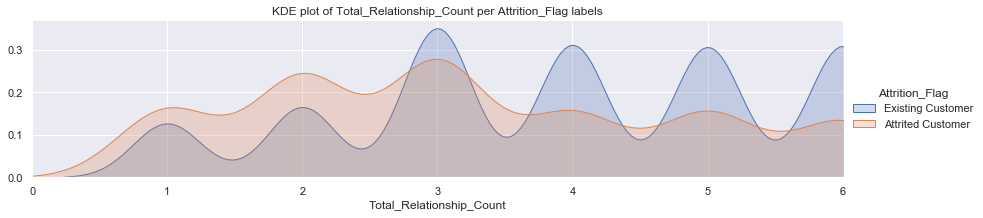

In [103]:
plot_num_var_kde(churn_data_with_id, 'Total_Relationship_Count') 

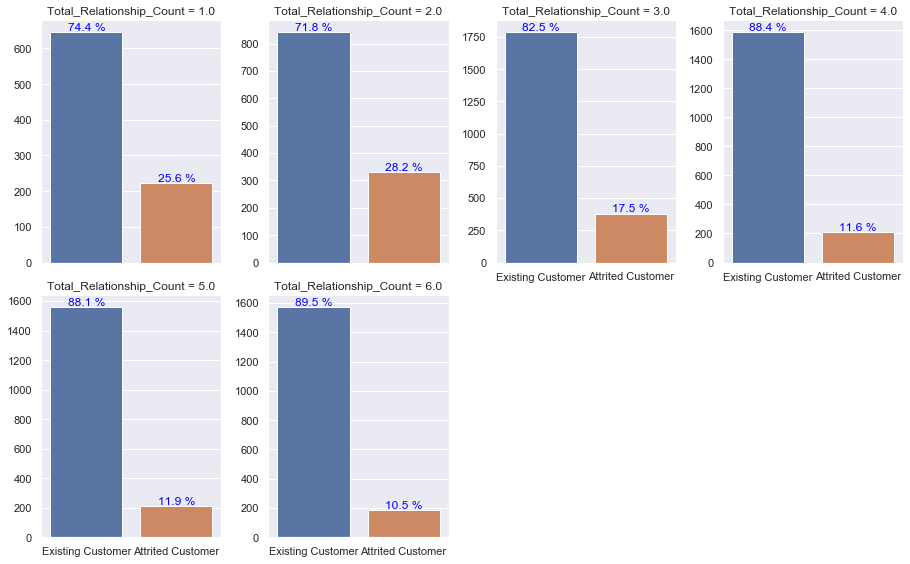

In [104]:
g = sns.catplot(
    x='Attrition_Flag', 
    col='Total_Relationship_Count', 
    kind='count', 
    data=churn_data_with_id, 
    sharey=False,
    col_wrap=4,
    height=4,
    aspect=.8
)
g.map_dataframe(annotate)
plt.show()

In [105]:
get_churn_percent_within_categorical_label('Total_Relationship_Count', churn_data_with_id)

Total_Relationship_Count  sample_size churn percentage (%)
0                       3.0          378              17.4757
1                       5.0          211              11.9209
2                       4.0          208              11.6007
3                       6.0          184              10.4784
4                       2.0          330               28.181
5                       1.0          222              25.6055

$\color{green} {\text{From the above, we can see there is a clear correlation between churn rate and the total no. of products held.}}$

For customers hold 4 or more products, we see there is a much lower churn percentage (`~10-12%`), whereas customers with only 1 or 2 products have a much higher churn percentage (`~26-28%`). On the other hand, customers with 3 products have a slightly higher churn percentage (`~17.5%`) as compared to that across all customers.

$\color{blue} {\text{E) No. of Months in the last 12 months}}$

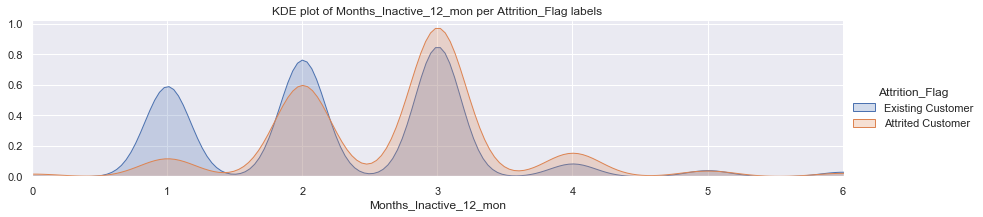

In [106]:
plot_num_var_kde(churn_data_with_id, 'Months_Inactive_12_mon') 

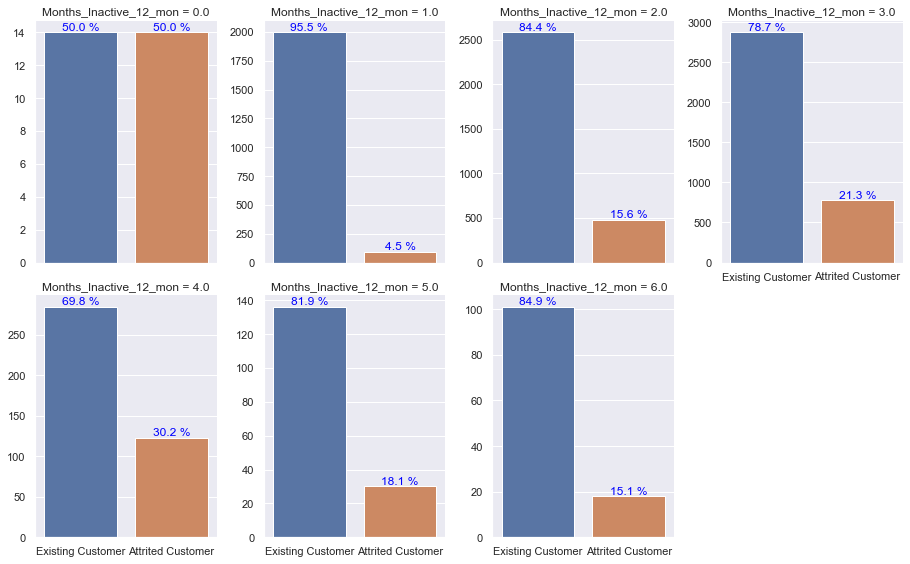

In [107]:
g = sns.catplot(
    x='Attrition_Flag', 
    col='Months_Inactive_12_mon', 
    kind='count', 
    data=churn_data_with_id, 
    sharey=False,
    col_wrap=4,
    height=4,
    aspect=.8
)
g.map_dataframe(annotate)
plt.show()

In [108]:
get_churn_percent_within_categorical_label('Months_Inactive_12_mon', churn_data_with_id)

Months_Inactive_12_mon  sample_size churn percentage (%)
0                     1.0           94              4.49546
1                     2.0          477              15.5933
2                     3.0          777              21.2877
3                     6.0           18              15.1261
4                     4.0          123              30.2211
5                     5.0           30              18.0723
6                     0.0           14                   50

$\color{green} {\text{From the above, we can again see there is a clear correlation between churn rate and the no. of inactive months.}}$

We can see customers with only 1 inactive month over the last 12 months are very unlikely to be churned (`~4.5%`), whereas those with 2 inactive months have more or less the same percentage (`~15.6%`) as that across all customers. 

On the other hand, customers with 3 or 4 inactive months have a much higher churn percentage (`21-30%`).

Here we ignore those customers with 0, 5 or 6 inactive months as there are only a handful of them and may not be very representative to draw any conclusions from.

$\color{green} {\text{Further question one may ask: are customers with 0 inactive months all new customers?}}$

$\color{blue} {\text{F) No. of Contacts in the last 12 months}}$

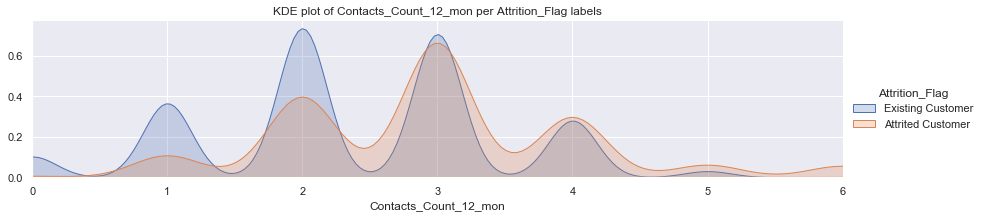

In [109]:
plot_num_var_kde(churn_data_with_id, 'Contacts_Count_12_mon') 

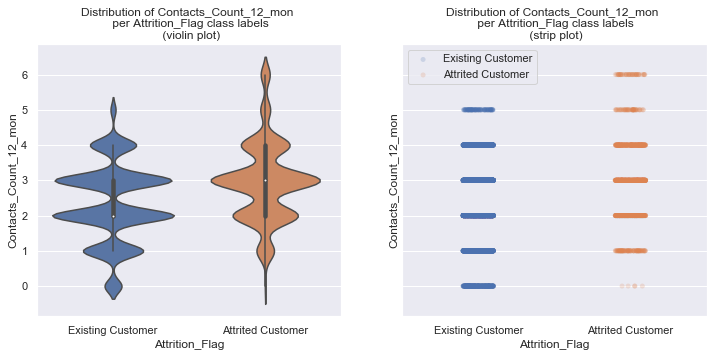

In [110]:
plot_num_var_vio_strip(churn_data_with_id, 'Contacts_Count_12_mon')

posx and posy should be finite values
posx and posy should be finite values


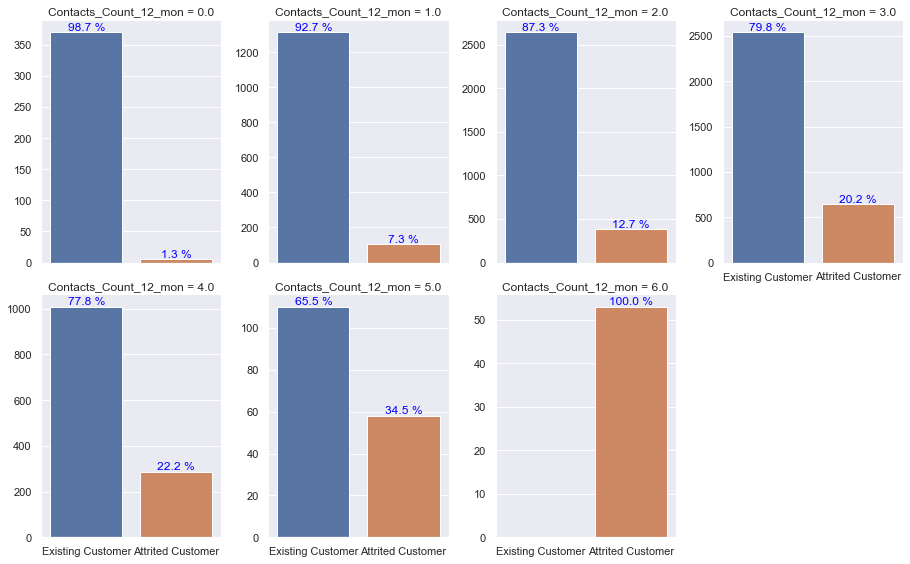

In [111]:
g = sns.catplot(
    x='Attrition_Flag', 
    col='Contacts_Count_12_mon', 
    kind='count', 
    data=churn_data_with_id, 
    sharey=False,
    col_wrap=4,
    height=4,
    aspect=.8
)
g.map_dataframe(annotate)
plt.show()

In [112]:
get_churn_percent_within_categorical_label('Contacts_Count_12_mon', churn_data_with_id)

Contacts_Count_12_mon  sample_size churn percentage (%)
0                    2.0          384              12.6775
1                    0.0            5              1.33333
2                    3.0          643              20.1947
3                    4.0          287              22.1793
4                    1.0          103              7.26888
5                    5.0           58              34.5238
6                    6.0           53                  100

$\color{green} {\text{From the above, we can again see there is a clear correlation between churn rate and the no. of contacts.}}$

We can see customers with only 1 and 2 contacts over the last 12 months are very unlikely to be churned (`7.3%` and `12.7%` respectively), whereas those with 3 or 4 contacts have a much higher churn percentage (`20-22%`).

$\color{green}{\text{!May not be representative!}}$

On the other hand, on the 'extreme' ends, customers with 0 contact over the last 12 months have a churn percentage of only `1.3%`, whereas customers with 5 or 6 contacts have a very high churn percentage (`35%` and `100%` respectively). Note that there are only a handful of them (<60 customers each) and may not be very representative to draw any conclusive arguments from.

$\color{green}{\text{Potential further question: are new & old customers distributed evenly across customers with different # of contacts?}}$

$\color{blue} {\text{G) Credit Limit on the Credit Card}}$

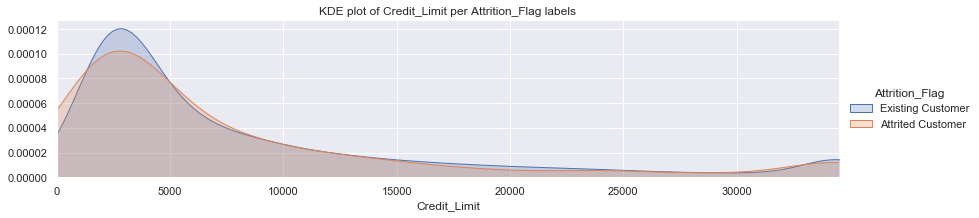

In [113]:
plot_num_var_kde(churn_data_with_id, 'Credit_Limit') 

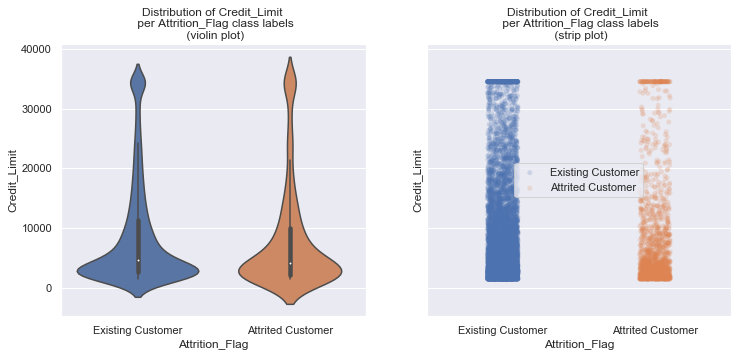

In [114]:
plot_num_var_vio_strip(churn_data_with_id, 'Credit_Limit')

Looking at the distributions above, we do not see much significant difference on credit limit between existing and attrited customers. 

We therefore conclude the credit limit is unlikely to have a big impact on the churn rate here. 

$\color{blue} {\text{H) Total Revolving Balance on the Credit Card}}$

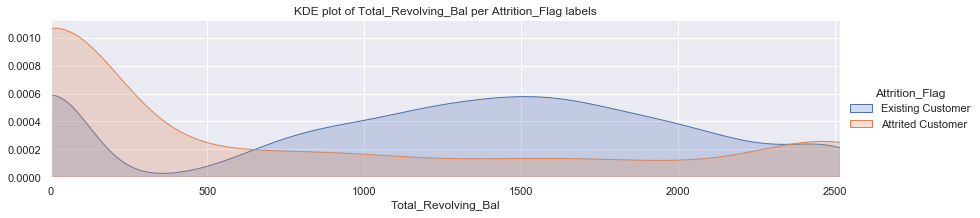

In [115]:
plot_num_var_kde(churn_data_with_id, 'Total_Revolving_Bal') 

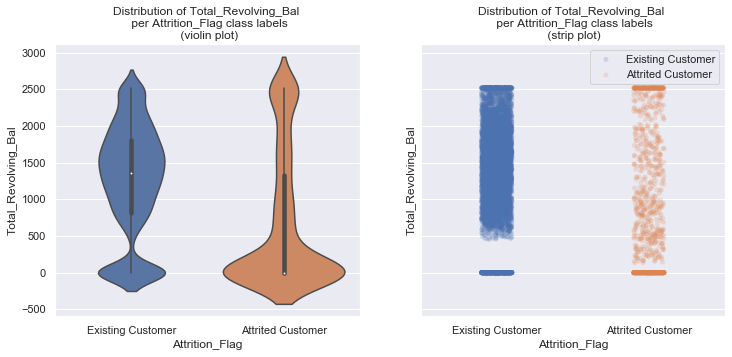

In [116]:
plot_num_var_vio_strip(churn_data_with_id, 'Total_Revolving_Bal')

From the above, we can see existing and attrited customers do have quite different distributions for the total revolving balance. 

Among the attrited customers, there is a large portion of them having a `$0` revloving account as compared to the existing customers. On the other hand, existing customers are more likely
to have a total revolving balance around `$1500` as seen from the second peak in the distribution.

We therefore conclude the total revolving balance is likely to have a moderate level of correlation with the churn rate.

$\color{blue} {\text{I) Open to Buy Credit Line (Average of last 12 months)}}$

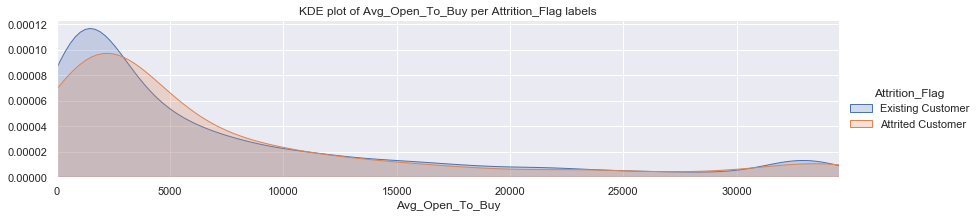

In [117]:
plot_num_var_kde(churn_data_with_id, 'Avg_Open_To_Buy') 

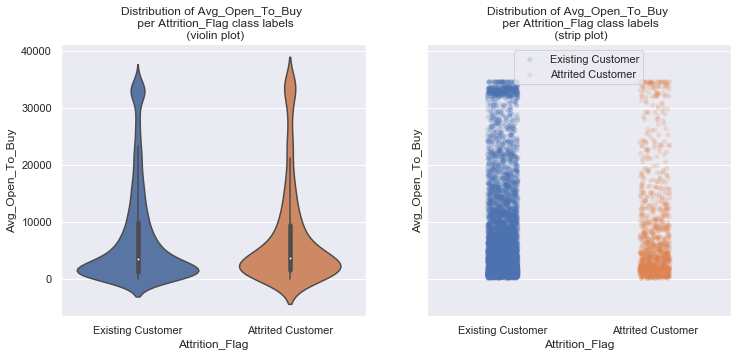

In [118]:
plot_num_var_vio_strip(churn_data_with_id, 'Avg_Open_To_Buy')

From the above, we can see existing and attrited customers have a very similar distribution of the average open-to-buy (last 12 months), with the lower tail peak slightly higher for existing customers.
 
We therefore conclude the average open-to-buy is unlikely to have a big impact on churn rate, though it does have some level of correlation with the churn rate.

Since there are missing entries in average open-to-buy (last 12 months), we are also interested in finding out if those missing entries have a very different churn rate as compared to the non-null entries.

In [119]:
# Labelling the missing `Avg_Open_To_Buy` entries for analysis
average_open_to_buy = churn_data_with_id.copy()
average_open_to_buy['Avg_Open_To_Buy'].fillna(-1, inplace=True)
average_open_to_buy['Missing_Avg_Open_To_Buy'] = average_open_to_buy['Avg_Open_To_Buy'] > 0

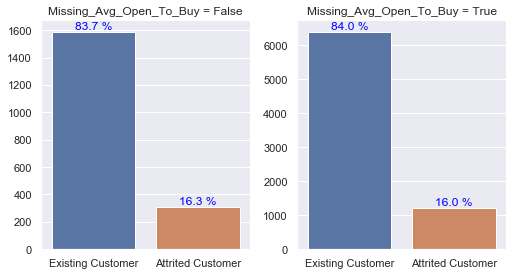

In [120]:
g = sns.catplot(
    x='Attrition_Flag', 
    col='Missing_Avg_Open_To_Buy', 
    kind='count', 
    data=average_open_to_buy, 
    sharey=False,
    col_wrap=4,
    height=4,
    aspect=.9
)
g.map_dataframe(annotate)
plt.show()

From the above, we do not find any significant difference in churn rate for customers with null and non-null average open-to-buy entries. This can again confirm these missing entries are likely to be missing completely at random.

$\color{blue} {\text{J) Change in Transaction Amount (Q4 over Q1)}}$

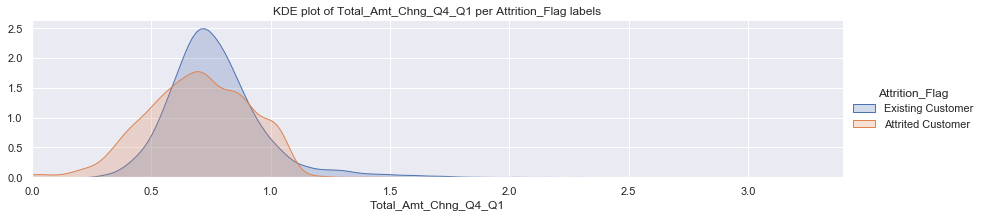

In [121]:
plot_num_var_kde(churn_data_with_id, 'Total_Amt_Chng_Q4_Q1') 

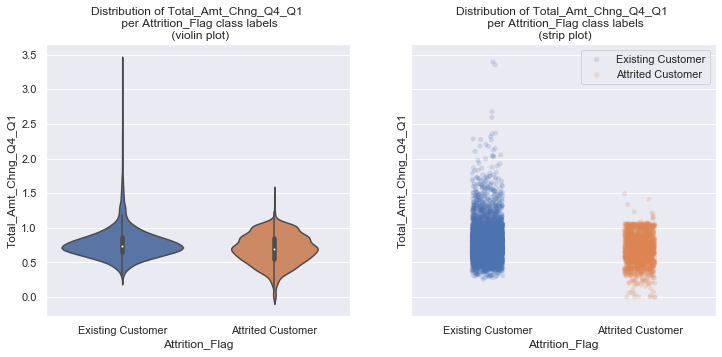

In [122]:
plot_num_var_vio_strip(churn_data_with_id, 'Total_Amt_Chng_Q4_Q1')

From the above, we can see existing and attrited customers have a very different distribution of the change in transaction amount (Q4 over Q1). 

For existing customers, we see there are quite some of them who spend more in Q4 as compared to Q1, whereas only a handful for the attrited counterpart. On the other hand, attrited customers also have a larger portion of them who see a `<0.6` change ratio as compared to existing customers.

We therefore conclude the change in transaction amount (Q4 over Q1) is likely to have quite some correlation on churn rate.

$\color{blue} {\text{K) Total Transaction Amount (Last 12 months)}}$

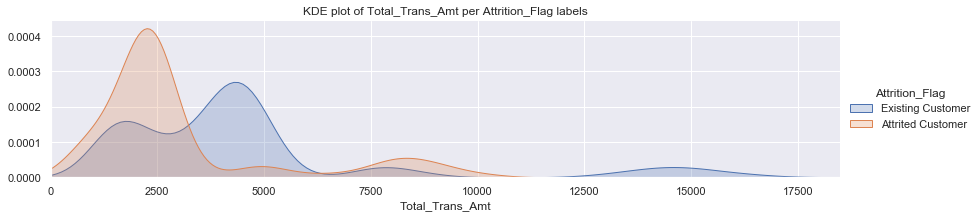

In [123]:
plot_num_var_kde(churn_data_with_id, 'Total_Trans_Amt') 

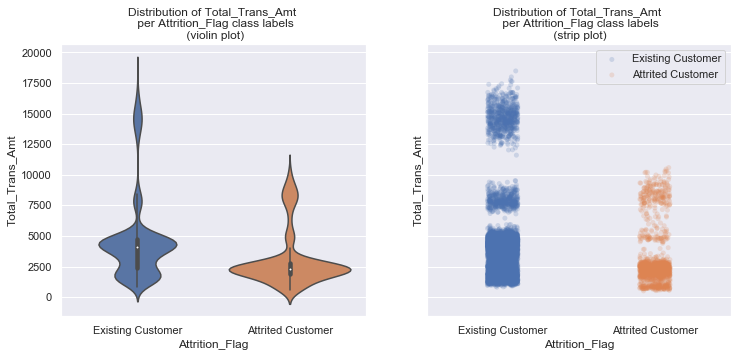

In [124]:
plot_num_var_vio_strip(churn_data_with_id, 'Total_Trans_Amt')

Unsurprisingly, from the above, we can see existing and attrited customers have a very different distribution of the total transaction amount (last 12 months).

For existing customers, we see there are quite some of them who spend more than `$10000` with the card product in the last 12 months, whereas there is only a handful of them for the attrited counterpart. On the other hand, there are a much larger portion of attrited customers have spent `$2500` in the last 12 months as compared to existing customers.

We therefore conclude the total transaction amount (last 12 months) is likely to have some strong correlation on the churn rate.

$\color{blue} {\text{L) Total Transaction Count (Last 12 months)}}$

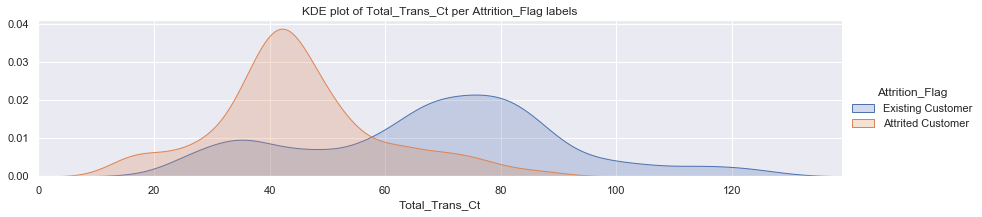

In [125]:
plot_num_var_kde(churn_data_with_id, 'Total_Trans_Ct') 

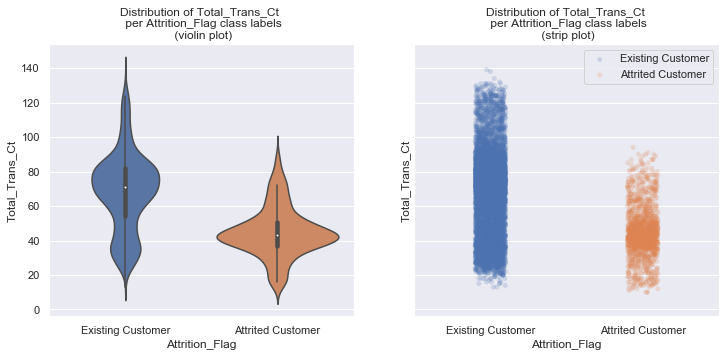

In [126]:
plot_num_var_vio_strip(churn_data_with_id, 'Total_Trans_Ct')

Again unsurprisingly, from the above, we can see existing and attrited customers have a very different distribution of the total transaction count (last 12 months).

For existing customers, we see there are quite some of them who `>80` transactions with the card product in the last 12 months, whereas there is only a handful of them for the attrited counterpart. On the other hand, there are a much larger portion of attrited customers have `<40` transactions in the last 12 months as compared to existing customers.

We therefore conclude the total transaction count (last 12 months) is likely to have some strong correlation on the churn rate.

$\color{blue} {\text{M) Change in Transaction Count (Q4 over Q1)}}$

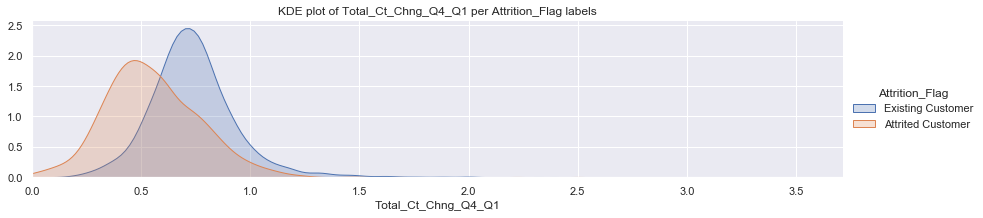

In [127]:
plot_num_var_kde(churn_data_with_id, 'Total_Ct_Chng_Q4_Q1') 

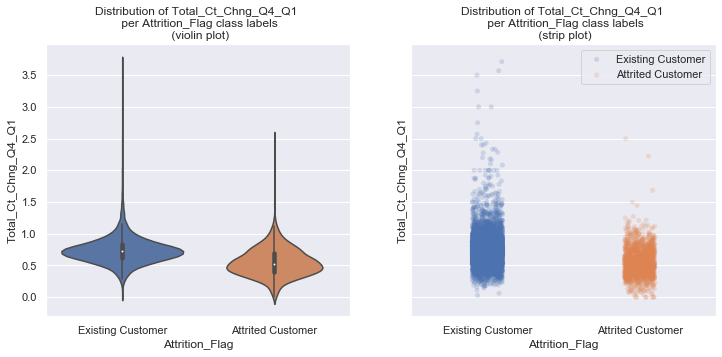

In [128]:
plot_num_var_vio_strip(churn_data_with_id, 'Total_Ct_Chng_Q4_Q1')

From the above, we can see existing and attrited customers have quite different distribution of the change in transaction count (Q4 over Q1). 

For existing customers, we see there are quite some of them who have more transactions in Q4 as compared to Q1, whereas only a handful for the attrited counterpart. On the other hand, attrited customers also have a larger portion of them who see a `<0.5` change ratio as compared to existing customers.

We therefore conclude the change in transaction count (Q4 over Q1) is likely to have quite some correlation on churn rate.

$\color{blue} {\text{N) Average Card Utilization Ratio}}$

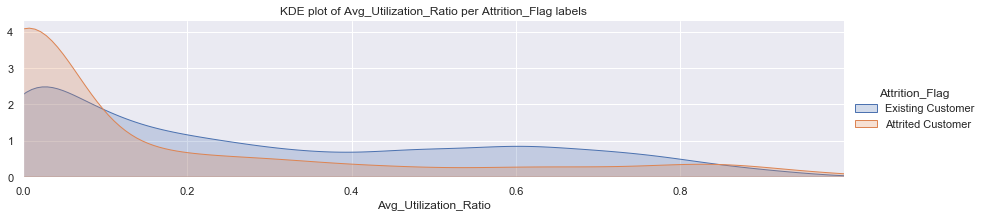

In [129]:
plot_num_var_kde(churn_data_with_id, 'Avg_Utilization_Ratio') 

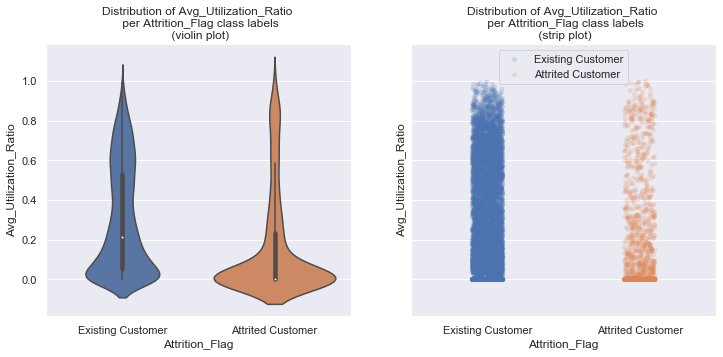

In [130]:
plot_num_var_vio_strip(churn_data_with_id, 'Avg_Utilization_Ratio')

From the above, we can see existing and attrited customers have quite different distribution of average card utilisation ratio, unsurprisingly with the existing customers have a higher utilisation ratio in general as compared to the attrited counterpart. 

On the other hand, attrited customers have a larger portion who have `0 or close to 0` utilisation ratio.

We therefore conclude the average card utilisation ratio is likely to have quite some correlation on churn rate.

# Feature engineering variables

In this section, we are going to perform some simple feature engineering and construct some new variables out of the existing feature variables.

$\color{blue} {\text{A) Average amount per transaction (last 12 months)}}$

First let us construct the `average amount per transaction` variable, defined as the `total transaction amount / total transaction count` over the last 12 months.

In [131]:
# columns of interest
transaction_columns = [
    'Total_Trans_Amt',
    'Total_Trans_Ct',
    'Attrition_Flag'
]

# compute the average amount per transaction (last 12 months)
transaction_df = churn_data_with_id[transaction_columns].copy()
transaction_df['average_amount_per_transaction'] = (
    transaction_df['Total_Trans_Amt'] / transaction_df['Total_Trans_Ct']
)

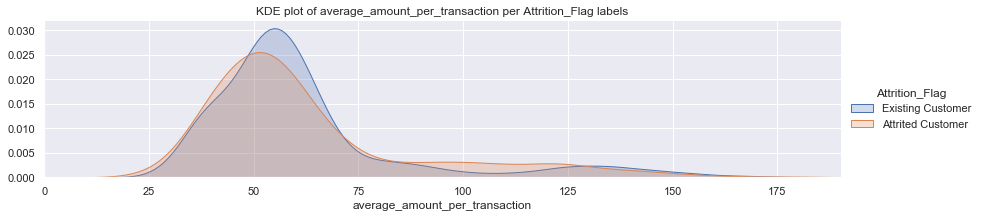

In [132]:
plot_num_var_kde(transaction_df, 'average_amount_per_transaction')

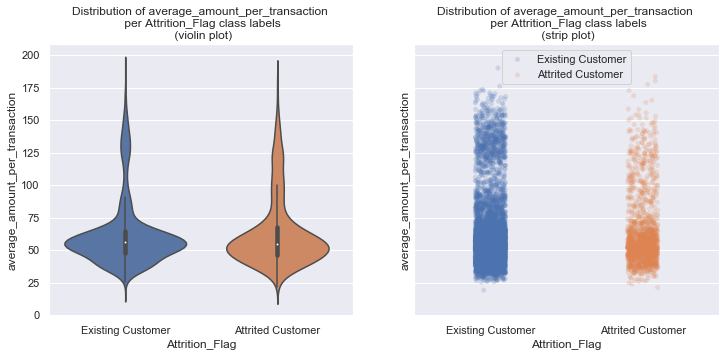

In [133]:
plot_num_var_vio_strip(transaction_df, 'average_amount_per_transaction')

From the above, we can see existing and attrited customers have very similar distributions of average amount per transaction. Existing customers in general have spent slightly more in each transaction over the last 12 months, though only slighly more.

We therefore conclude this average amount per transaction variable is likely to have only weak correlation with the churn rate and is unlikely to be helpful in predicting churn rate.

$\color{blue} {\text{B) Increase/decrease in Transaction Amount (Q4 vs Q1)}}$

Next we construct the `transaction amount change type` variable, defined as the whether the ratio `change in transaction amount (Q4 over Q1)` is larger than 1 or not.

In [134]:
# columns of interest
transaction_amount_change_columns = [
    'Total_Amt_Chng_Q4_Q1',
    'Attrition_Flag'
]

# compute whether the change is an increase/decrease
transaction_amount_change_df = churn_data_with_id[
    transaction_amount_change_columns
].copy()
transaction_amount_change_df['amount_change_type'] = (
    transaction_amount_change_df['Total_Amt_Chng_Q4_Q1'].apply(
        lambda x: 'increase' if x > 1 else (
            'decrease' if x < 1 else 'same'
        )
    )
)

posx and posy should be finite values
posx and posy should be finite values


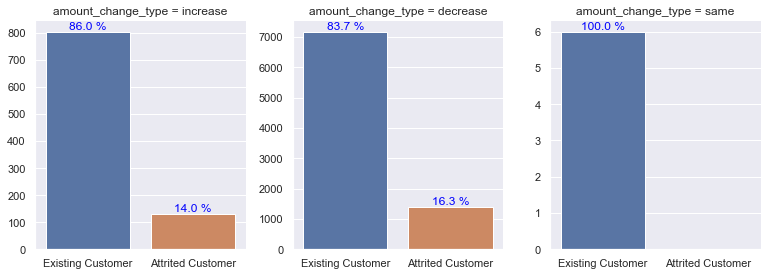

In [135]:
g = sns.catplot(
    x='Attrition_Flag', 
    col='amount_change_type', 
    kind='count', 
    data=transaction_amount_change_df, 
    sharey=False,
    col_wrap=4,
    height=4,
    aspect=.9
)
g.map_dataframe(annotate)
plt.show()

In [136]:
get_churn_percent_within_categorical_label('amount_change_type', transaction_amount_change_df)

amount_change_type sample_size churn percentage (%)
0           increase         131              14.0107
1           decrease        1402              16.3422
2               same           0                    0

Although the change in transaction amount (Q4 over Q1) has a strong correlation with the churn rate, by converting this change ratio to the simple `transaction amount change type` variable, 
the resulting correlation becomes much weaker.

We therefore conclude this `transaction amount change type` variable is unlikely to be very helpful.

$\color{blue} {\text{C) Increase/decrease in Transaction Count (Q4 vs Q1)}}$

Next, similar to the transaction amount, we construct a similar `transaction count change type` variable, defined as the whether the ratio `change in transaction count (Q4 over Q1)` is larger than 1 or not.

In [137]:
# columns of interest
transaction_count_change_columns = [
    'Total_Ct_Chng_Q4_Q1',
    'Attrition_Flag'
]

# compute whether the change is an increase/decrease
transaction_count_change_df = churn_data_with_id[
    transaction_count_change_columns
].copy()
transaction_count_change_df['count_change_type'] = (
    transaction_count_change_df['Total_Ct_Chng_Q4_Q1'].apply(
        lambda x: 'increase' if x > 1 else (
            'decrease' if x < 1 else 'same'
        )
    )
)

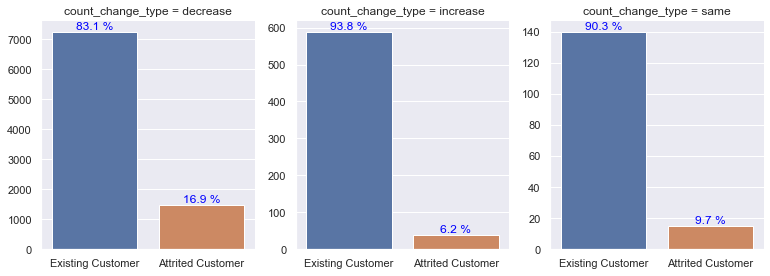

In [138]:
g = sns.catplot(
    x='Attrition_Flag', 
    col='count_change_type', 
    kind='count', 
    data=transaction_count_change_df, 
    sharey=False,
    col_wrap=4,
    height=4,
    aspect=.9
)
g.map_dataframe(annotate)
plt.show()

In [139]:
get_churn_percent_within_categorical_label('count_change_type', transaction_count_change_df)

count_change_type sample_size churn percentage (%)
0          decrease        1479               16.928
1          increase          39              6.21019
2              same          15              9.67742

Unlikely the `transaction amount change type` variable, `transaction count change type` do retain the strong correlation with the churn rate. However, there are only a handful of customers with a non-negative change in transaction count and thus this observation may not be representative enough.

# Correlation study

We now study how strong each feature variables are correlated with the target (`Attrition_Flag`) in this customer dataset. 

In order to compute the correlation matrix and corresponding heatmap, we need first to encode the target `Attrition_Flag` in numeric forms.

In [140]:
churn_data_with_id_encoded = churn_data_with_id.copy()

# drop the customer ID column
churn_data_with_id_encoded.drop(['CLIENTNUM'], inplace=True, axis=1)

churn_data_with_id_encoded['is_attrited'] = (
    churn_data_with_id_encoded['Attrition_Flag'].apply(
        lambda x: 1 if x == 'Attrited Customer' else 0
    )
)

$\color{blue} {\text{Numerical variables}}$ 

First let us perform the correlation analysis between the numerical variables and the target `Attrition_Flag`.

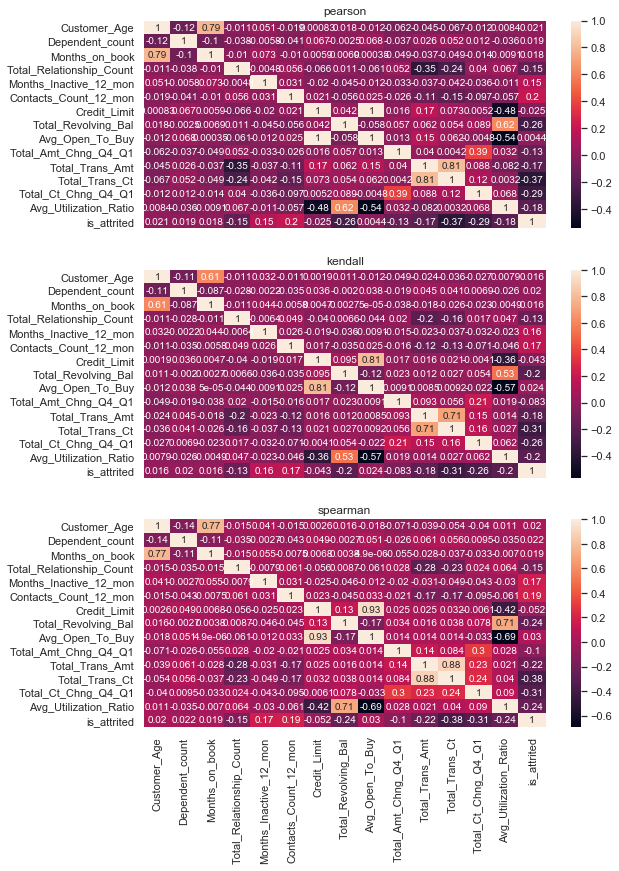

In [141]:
corr_type = ['pearson', 'kendall', 'spearman']
fig, ax = plt.subplots(nrows=3, sharex=True, figsize =(9,13) )

# correlation heatmap for numeric variables only
i=0
for corr in corr_type:
    df_corr = churn_data_with_id_encoded.corr(method=corr)
    sns.heatmap(df_corr, annot=True, annot_kws={"size": 10}, ax=ax[i])
    ax[i].set_title(corr)
    i+=1

In [142]:
churn_data_with_id_encoded.corr()['is_attrited']

Customer_Age                0.020526
Dependent_count             0.019436
Months_on_book              0.018083
Total_Relationship_Count   -0.152528
Months_Inactive_12_mon      0.150597
Contacts_Count_12_mon       0.204946
Credit_Limit               -0.025040
Total_Revolving_Bal        -0.261241
Avg_Open_To_Buy             0.004443
Total_Amt_Chng_Q4_Q1       -0.130837
Total_Trans_Amt            -0.168894
Total_Trans_Ct             -0.371557
Total_Ct_Chng_Q4_Q1        -0.291149
Avg_Utilization_Ratio      -0.176282
is_attrited                 1.000000
Name: is_attrited, dtype: float64

From the above heatmaps and the correlation matrix, we can see the `[Total_Relationship_Count, Total_Revolving_Bal, Total_Amt_Chng_Q4_Q1, Total_Trans_Amt, Total_Trans_Ct, Total_Ct_Chng_Q4_Q1, Avg_Utilization_Ratio]` have quite strong negative correlation with the `Attrition_Flag`, with the Pearson correlation coefficient `<-0.13`.

On the other hand, `[Months_Inactive_12_mon, Contacts_Count_12_mon]` have quite some strong positive correlation with `Attrition_Flag`, with the Pearson correlation coefficient `0.15` and `0.20` respectively.

$\color{blue} {\text{Categorical variables}}$ 

Next we perform the correlation analysis between the categorical variables and the target `Attrition_Flag`. Before we proceed, we need to first encode these categorical variables.

In [143]:
# categorical columns
categorical_columns = [
    'Gender',
    'Education_Level',
    'Marital_Status',
    'Income_Category',
    'Card_Category',
    'is_attrited'
]

churn_data_with_id_encoded_cat_only = churn_data_with_id_encoded[
    categorical_columns
].copy()

# Encode the categorical variables
for col in categorical_columns[:-1]:
    churn_data_with_id_encoded_cat_only[col] = (
        churn_data_with_id_encoded_cat_only[col].astype('category')
    )
    churn_data_with_id_encoded_cat_only[f'{col}_encoded'] = (
        churn_data_with_id_encoded_cat_only[col].cat.codes
    )

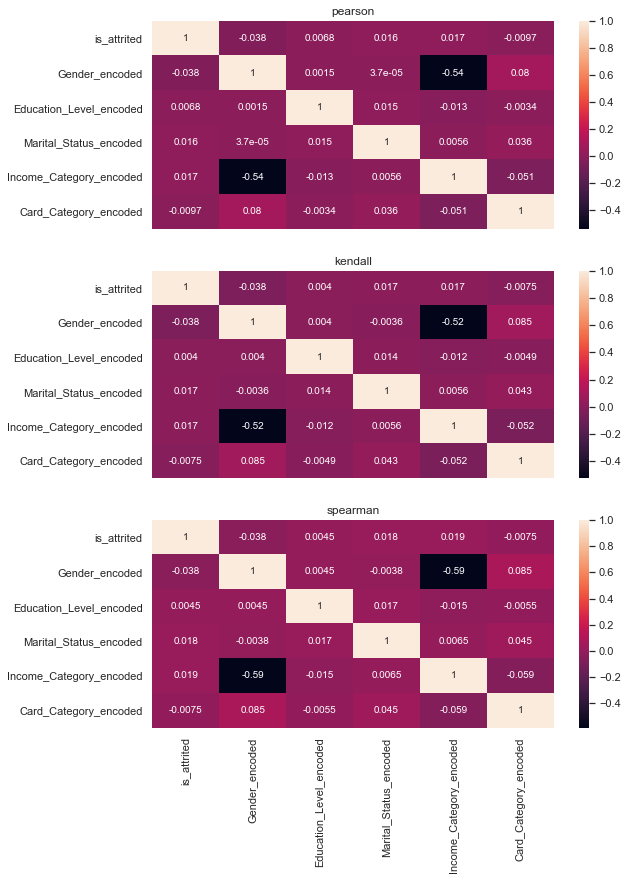

In [144]:
corr_type = ['pearson', 'kendall', 'spearman']
fig, ax = plt.subplots(nrows=3, sharex=True, figsize =(9,13) )
i=0

# correlation heatmap for numeric variables only
for corr in corr_type:
    df_corr = churn_data_with_id_encoded_cat_only.corr(method=corr)
    sns.heatmap(df_corr, annot=True, annot_kws={"size": 10},ax=ax[i])
    ax[i].set_title(corr)
    i+=1

From the above heatmaps, we can see all of these categorical variables have very weak correlation with the `Attrition_Flag`, with the magnitude of Pearson correlation coefficient `< O(0.1)`. This agrees with the analysis in the previous section.

Aside: We also plot the pairwise relationships between some numerical variables per each target class in the dataset in the following. Not too surprisingly, we can see there is a clear indication of collinearity between `Avg_Open_To_Buy` and `Credit_Limit`. 

<Figure size 1080x1440 with 0 Axes>

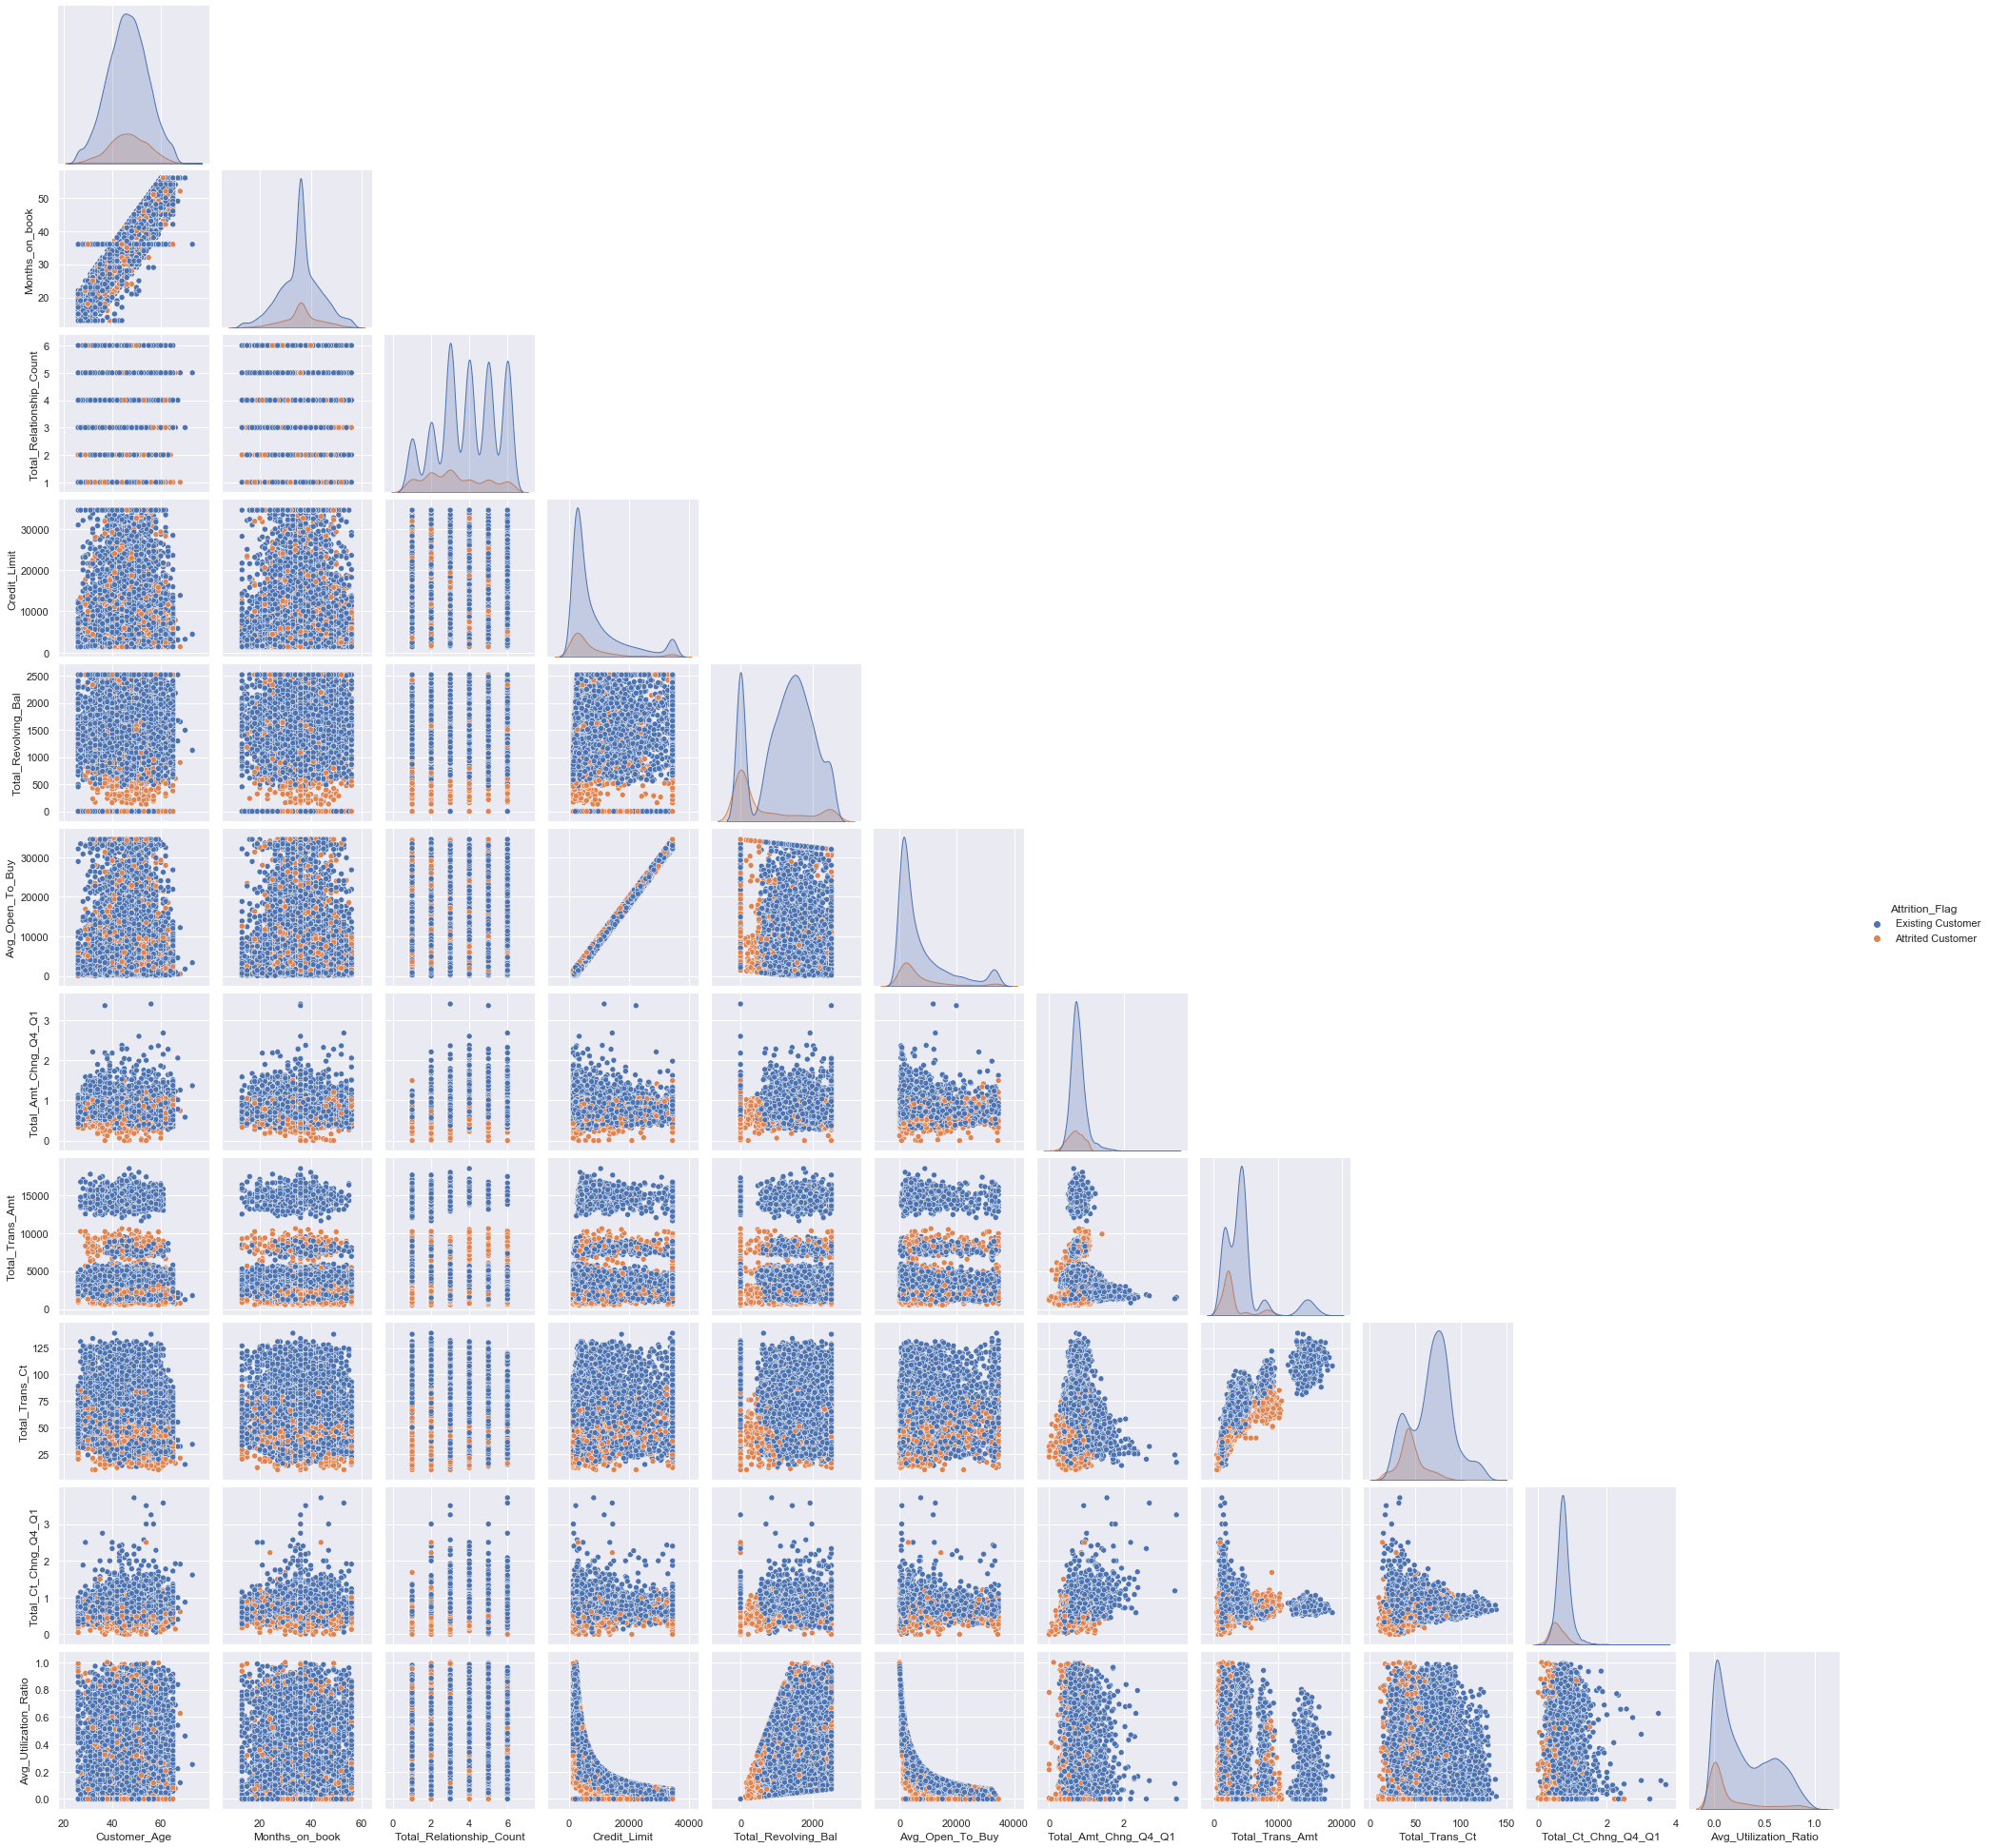

In [145]:
churn_data_df_numerical_only = churn_data_with_id.copy()
churn_data_df_numerical_only = churn_data_df_numerical_only.drop(columns=['CLIENTNUM'])

# get the numerical (non-categorical) columns, except the customer ID
non_categorical = list(
    np.where(churn_data_df_numerical_only.dtypes != 'object')
)
numercial_columns = churn_data_df_numerical_only.columns[non_categorical]

# remove also the ordinal-like numerical variables
numercial_columns = [
    col for col in numercial_columns 
    if col not in ('Dependent_count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon')
]

# filter out the non-numerical columns (except the target Attrition_Flag)
churn_data_df_numerical_only = churn_data_df_numerical_only[
    [*numercial_columns, 'Attrition_Flag']
]

# Plot pairwise relationships in the dataset
sns.set(font_scale=1)
fig = plt.figure(figsize =(15, 20))
g = sns.pairplot(
    churn_data_df_numerical_only, hue='Attrition_Flag', corner=True
)
fig.tight_layout()

For completeness, we also verify the 9-digit customer ID have very little correlation with the churn rate as one expects.

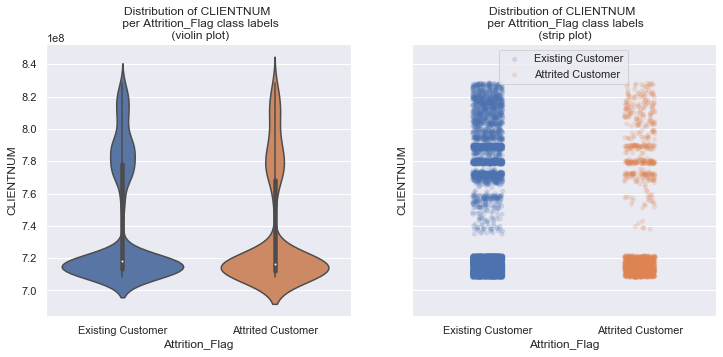

In [146]:
plot_num_var_vio_strip(churn_data_with_id, 'CLIENTNUM')

Aside, some other further questions one may ask beyond the given information:

1) Are there any reactivated customers, i.e. who were churned before but rejoin as a customer later on, in this dataset?

2) If so, how are they distributed across various categorical groups including the target?

3) Does this dataset include any fraudsters or customers violating (card) contract terms?

4) Are there any change in contract terms or APR (Annual Percentage Rate) over the period of this training dataset?

5) Are there any customers whose attributes e.g. income, marital status or number of dependents change over the period of this training dataset?

# 2) Predicting churn

After exploratory data analysis, we now move to build tree-based models to predict the churn  target variable (`Attrition_Flag`), which is a supervised ML classification problem.

$\color{blue} {\text{A) Dealing with missing values}}$ 

Before building any models, we need to preprocess the data first. In particular, we need to consider how to deal with the missing entries. As discussed in the EDA section, those entries with missing customer ID have all feature variables missing as well and thus we will drop all those entries here. The customer ID is also dropped as we do not expect it to have any predictive power.

We will also drop the `Avg_Open_To_Buy` variable since it likely to contain the same useful amount of information as `Avg_Utilization_Ratio` while has some missing entries. 

In [147]:
churn_data = churn_raw_data.copy()
all_columns = churn_data.columns

# categorical columns to keep
categorical_columns = [
    'Gender',
    'Education_Level',
    'Marital_Status',
    'Income_Category',
    'Card_Category'
]

# numerical columns to keep
numerical_columns = [
    col for col in all_columns 
    if col not in (*categorical_columns, 'CLIENTNUM', 'Attrition_Flag', 'Avg_Open_To_Buy')
]

In [148]:
columns_to_kept = [
    *categorical_columns, *numerical_columns, 'Attrition_Flag'
]

# drop the missing entries
churn_data = churn_data[columns_to_kept].dropna()

In [149]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9520 entries, 0 to 9619
Data columns (total 19 columns):
Gender                      9520 non-null object
Education_Level             9520 non-null object
Marital_Status              9520 non-null object
Income_Category             9520 non-null object
Card_Category               9520 non-null object
Customer_Age                9520 non-null float64
Dependent_count             9520 non-null float64
Months_on_book              9520 non-null float64
Total_Relationship_Count    9520 non-null float64
Months_Inactive_12_mon      9520 non-null float64
Contacts_Count_12_mon       9520 non-null float64
Credit_Limit                9520 non-null float64
Total_Revolving_Bal         9520 non-null float64
Total_Amt_Chng_Q4_Q1        9520 non-null float64
Total_Trans_Amt             9520 non-null float64
Total_Trans_Ct              9520 non-null float64
Total_Ct_Chng_Q4_Q1         9520 non-null float64
Avg_Utilization_Ratio       9520 non-null float6

$\color{blue} {\text{B) Categorical Labels Encoding}}$

Next we need to encode the categorical labels in the dataset. Note that among the categorical variables, `[Education_Level, Income_Category, Card_Category]` are ordinal, whereas `[Gender, Marital_Status]` are not.

For simplicity, we will use ordinal encoder for those ordinal variables (where we treat 'Unknown' as 0) and one-hot encoder for the non-ordinal variables. In practice, one may need to take more consideration in how to deal with the 'Unknown' classes, e.g. do some further in-depth analysis to understand what may cause this label and perform imputation if necessary.

$\color{green} {\text{Aside: Note that label encoding step is not a must for training tree-based models}}$ 

In [150]:
from sklearn.preprocessing import OrdinalEncoder

# ordinal columns
ordinal_columns = [
    'Education_Level',
    'Income_Category',
    'Card_Category'
]

# Ordinal labels order
education_categories = [
    'Unknown', 'Uneducated', 'High School', 'College',  
    'Graduate', 'Post-Graduate', 'Doctorate'
]
income_categories = [
    'Unknown', 'Less than $40K', '$40K - $60K', '$60K - $80K', 
    '$80K - $120K', '$120K +'
]
card_categories = [
    'Blue', 'Silver', 'Gold', 'Platinum'
]

# Ordinal encoder
ordinal_encoder = OrdinalEncoder(
    categories=[education_categories, income_categories, card_categories],
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

In [151]:
from sklearn.preprocessing import OneHotEncoder

# non-ordinal columns
non_ordinal_columns = [
    'Gender',
    'Marital_Status'
]

# one-hot encoder
one_hot_encoder = OneHotEncoder(
    drop=['M', 'Unknown']
)

$\color{blue} {\text{C) Remove outliers & scaling (not implemented)}}$

In general data preprocessing pipelines, the next steps are removing outliers and perform feature scaling. However, since we are working with tree-based models which are in general very robust against outliers and scaling, we will skip these processing steps here.

Aside: one can build another pipeline with removing outliers and scaling steps and compare that without those steps to see if the model(s) is indeed robust.}}$

$\color{blue} {\text{Full data preprocessing pipeline}}$

Now we can build a full data preprocessing pipeline. 

In [152]:
from sklearn.compose import ColumnTransformer

full_preprocessing_pipeline = ColumnTransformer(
    [
        ('numeric', 'passthrough', numerical_columns),
        ('ordinal', ordinal_encoder, ordinal_columns),
        ('non_ordinal', one_hot_encoder, non_ordinal_columns),
    ]
)

# Train tree-based models

Next finally we are about to train some machine learning models to predict the churn rate. For simplicity and model interpretability  (and also as an requirement) reasons, we will choose only tree-based models in the following. 

We would also consider some ensemble models (including the random forset) using some standard bagging and boosting methods as well in addition to single tree models.

In order to validate our results, we will leave out `10%` of the data as `test` set and not include them in any training or preprocessing pipeline.

In [153]:
from sklearn.model_selection import StratifiedShuffleSplit

# Specify the feature and target variables
churn_data = churn_data.reset_index(drop=True)
feature_df = churn_data.drop(columns=['Attrition_Flag'])
target_var = churn_data['Attrition_Flag']

# recast the target variable to numeric form
target_var = target_var.apply(
    lambda x: 1 if x == 'Attrited Customer' else 0
)

# leave out 10% of data as test set which are used for 
# final model evaluation but not in any training steps
split_generators = StratifiedShuffleSplit(
    n_splits=1, test_size=0.1, random_state=42
)
for train_index, test_index in split_generators.split(feature_df, target_var):
    feature_df, feature_df_test = feature_df.iloc[train_index, :], feature_df.iloc[test_index, :]
    target_var, target_var_test = target_var[train_index], target_var[test_index]
    
# reset index
feature_df = feature_df.reset_index(drop=True)
target_var = target_var.reset_index(drop=True)

# Model performance evaluation and baseline model(s)

Before training the models, we would first need to define the model performance metric and a baseline model to compare with. 

Since we are trying to predict whether a customer is churned or not, we are mostly concerned with getting the number of false negatives (i.e. churned customers wrongly predicted as not churned) as low as possible, but less concerned on false positives (i.e. not churned customers predicted as churned). Thus the metric `recall`, defined as `true positives / (true positives + false negatives)`, is most appropriate here (One may also consider using the `f1 score` instead). 

For detailed analysis, we will also compute and plot the confusion matrix in the following.

$\color{blue} {\text{Baseline model(s)}}$

Firstly, we would use a very simple one which predicts all customers as not attrited for simplicity here.

In [154]:
# baseline model I, assuming all customers are not attrited
from sklearn.metrics import recall_score, accuracy_score

predicted_baseline_I = [0] * len(target_var)

baseline_I_recall = recall_score(
    target_var.tolist(), predicted_baseline_I
)
baseline_I_accuracy = accuracy_score(
    target_var.tolist(), predicted_baseline_I
)

print('Baseline model I, simply assuming all customers are not attrited\n')
print(f"Recall: {baseline_I_recall}")
print(f"Accuracy: {round(baseline_I_accuracy, 2)}")

Baseline model I, simply assuming all customers are not attrited

Recall: 0.0
Accuracy: 0.84


In [155]:
from sklearn.metrics import confusion_matrix

confusion_matrix(target_var.tolist(), predicted_baseline_I)

array([[7188,    0],
       [1380,    0]])

Because the dataset is imbalanced in terms of customer churn, we can see though a model simply 'predicting' all customers are not attrited have a high accuracy of `84%`, it has 0 recall score and is very much useless in predicting customer churn use cases.

$\color{green} {\text{Q: Any other reasonable simple baseline models?}}$

$\color{blue} {\text{tree-based ML models}}$

Now we move to train our tree-based models. Here we will consider the following built-in sklearn models (with default settings):

`[Decision Tree Classifier, Extra Tree Classifier, AdaBoost Classifier, Bagging Classifier, RandomForestClassifier]`

In [156]:
# List of Machine Learning tree-based classification models considered
# (with default hyperparameters)

from sklearn import tree, ensemble

MLA_classifier = [
    # Decision Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    # Ensemble Methods
    ensemble.AdaBoostClassifier(),  # base estimator is decision tree classifer by default
    ensemble.BaggingClassifier(),   # base estimator is decision tree classifer by default
    ensemble.RandomForestClassifier()  
]

**Note**: In sklearn, Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [157]:
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline

# split dataset for cross-validation with Stratified Shuffle Split and 
# run model 10-fold times with 80/20 split on the training data (90% of total)
cv_split = StratifiedShuffleSplit(
    n_splits=10, test_size=0.2, random_state=0
) 

# create dataframe to compare different machine learning classifiers (using recall score)
MLA_columns = [
    'ML_classifier_name', 'ML_parameters','train_recall_score_mean', 
    'validate_recall_score_mean', 'validate_recall_score_3*std', 
    'validate_recall_score_min', 'mean_running_time'
]
model_performance_df = pd.DataFrame(columns = MLA_columns)

#index through MLA and save performance to table
row_index = 0
for alg in MLA_classifier:
    
    model = Pipeline(
        steps=[
            ('preprocessing', full_preprocessing_pipeline),
            ('predictor', alg)
        ]
    )
    
    # Label the feature variables as X and target as Y
    X = feature_df
    y = target_var
    
    # set name and parameters
    MLA_name = alg.__class__.__name__
    model_performance_df.loc[row_index, 'ML_classifier_name'] = MLA_name
    model_performance_df.loc[row_index, 'ML_parameters'] = str(alg.get_params())
    
    # score model with cross validation
    cv_results = cross_validate(
        model, X, y, scoring='recall', cv = cv_split, return_train_score=True
    )

    model_performance_df.loc[row_index, 'mean_running_time'] = cv_results['fit_time'].mean()
    model_performance_df.loc[row_index, 'train_recall_score_mean'] = cv_results['train_score'].mean()
    model_performance_df.loc[row_index, 'validate_recall_score_mean'] = cv_results['test_score'].mean()   
    model_performance_df.loc[row_index, 'validate_recall_score_min'] = cv_results['test_score'].min() 
    
    # Compute the spread of the test_f1_score
    model_performance_df.loc[row_index, 'validate_recall_score_3*std'] = cv_results['test_score'].std()*3  
    
    row_index+=1
    
# sort the results by validate score
model_performance_df.sort_values(
    by = ['validate_recall_score_mean'], ascending = False, inplace = True
)

In [158]:
# print the results
model_performance_df

ML_classifier_name                                      ML_parameters  \
2      AdaBoostClassifier  {'algorithm': 'SAMME.R', 'base_estimator': Non...   
3       BaggingClassifier  {'base_estimator': None, 'bootstrap': True, 'b...   
4  RandomForestClassifier  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...   
0  DecisionTreeClassifier  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...   
1     ExtraTreeClassifier  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...   

  train_recall_score_mean validate_recall_score_mean  \
2                0.855978                   0.842029   
3                0.981431                   0.816667   
4                0.999909                   0.811957   
0                       1                   0.800725   
1                       1                   0.589855   

  validate_recall_score_3*std validate_recall_score_min mean_running_time  
2                    0.037716                  0.826087          0.372236  
3                    0.048901                  0.793478           0.33707  
4                   0.0619565                  0.782609          0.782353  
0                   0.0662954                  0.768116         0.0774643  
1                    0.127392                  0.528986         0.0247514

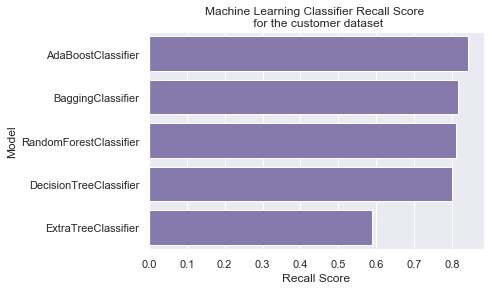

In [159]:
sns.barplot(
    x='validate_recall_score_mean', y = 'ML_classifier_name', 
    data = model_performance_df, color = 'm'
)
plt.title('Machine Learning Classifier Recall Score \n for the customer dataset')
plt.xlabel('Recall Score')
plt.ylabel('Model')
plt.show()

From the above, we can see although most models (apart from `ExtraTreeClassifier`) have a high recall score of `~0.8`, all but the `AdaBoostClassifier` (with a base estimator of 
`DecisionTreeClassifier` initialized with `max_depth=1`) suffer overfitting problems, with the training recall score `>0.98`.

The `AdaBoostClassifier` model not only does not suffer from overfitting issue, it also has one of the lowest spread and the highest minimum in recall score across the 10-fold validation sets. The model takes longer to run though, but still much quicker as compared to `RandomForestClassifier`.

# Model performance on the test set 

Next we will evaluate the models performance again, but this time train on the full training sets and test on the left out test set.

In [160]:
# create dataframe to compare different machine learning classifiers (using recall score)
performance_columns = [
    'ML_classifier_name', 
    'ML_parameters', 
    'train_recall_score', 
    'test_recall_score'
]
model_performance_test_df = pd.DataFrame(columns = performance_columns)

#index through MLA and save performance to table
row_index = 0
for alg in MLA_classifier:
    
    model = Pipeline(
        steps=[
            ('preprocessing', full_preprocessing_pipeline),
            ('predictor', alg)
        ]
    )
    
    # Label the feature variables as X and target as Y
    X = feature_df
    y = target_var
    
    # set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_name = MLA_name.replace('Classifier', '')
    model_performance_test_df.loc[row_index, 'ML_classifier_name'] = MLA_name
    model_performance_test_df.loc[row_index, 'ML_parameters'] = str(alg.get_params())
    
    # fit and predict
    model.fit(X, y)
    train_predicted = model.predict(X)
    test_predicted = model.predict(feature_df_test)
    
    # compute recall scores
    model_performance_test_df.loc[row_index, 'train_recall_score'] = recall_score(
        y, train_predicted 
    )
    model_performance_test_df.loc[row_index, 'test_recall_score'] = recall_score(
        target_var_test, test_predicted 
    )
    row_index+=1
    
# sort the results by 
model_performance_test_df.sort_values(
    by = ['test_recall_score'], ascending = False, inplace = True
)

In [161]:
# print the results
model_performance_test_df

ML_classifier_name                                      ML_parameters  \
2           AdaBoost  {'algorithm': 'SAMME.R', 'base_estimator': Non...   
3            Bagging  {'base_estimator': None, 'bootstrap': True, 'b...   
4       RandomForest  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...   
0       DecisionTree  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...   
1          ExtraTree  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...   

  train_recall_score test_recall_score  
2           0.855797          0.843137  
3           0.980435          0.816993  
4                  1          0.777778  
0                  1          0.764706  
1                  1          0.607843

We can see the test set results are very much consistent with the previous validation sets results, verifying `AdaBoostClassifier` is the best model with no overfitting issue.

We will therefore choose `AdaBoostClassifier` as our ML model to predict the churn rate.

# Hyperparameter tuning 

To improve our ML model, we will next perform hyperparameter tuning. Here we will tune the `[n_estimators, learning_rate]` hyperparameters for our `AdaBoostClassifier` model.

In [162]:
# define the hyperparameter grid of values to search from
grid = dict()
grid['n_estimators'] = [10, 50, 100, 500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]

In [163]:
parameters = [
    {
        'predictor__n_estimators': grid['n_estimators'],
        'predictor__learning_rate': grid['learning_rate']
    }
]

In [164]:
from sklearn.model_selection import GridSearchCV

# define the evaluation procedure
cv_split = StratifiedShuffleSplit(
    n_splits=10, test_size=0.2, random_state=1
) 

# define the grid search procedure
churn_model = Pipeline(
    steps=[
        ('preprocessing', full_preprocessing_pipeline),
        ('predictor', ensemble.AdaBoostClassifier())
    ]
)
grid_search = GridSearchCV(
    estimator=churn_model, param_grid=parameters, cv=cv_split, scoring='recall'
)

# execute the grid search
X = feature_df
y = target_var
grid_result = grid_search.fit(X, y)

In [165]:
# summarise the best score and corresponding hyperparameters
best_hyperparameters = {
    'learning_rate': grid_result.best_params_['predictor__learning_rate'],
    'n_estimators': grid_result.best_params_['predictor__n_estimators'],  
}
default_hyperparameters = {
    'learning_rate': 1.0,
    'n_estimators': 50,  
}

print(f"Default hyperparameters tested previously: {default_hyperparameters}")
print(f"Best score: {round(grid_result.best_score_, 2)} using {best_hyperparameters}")

Default hyperparameters tested previously: {'learning_rate': 1.0, 'n_estimators': 50}
Best score: 0.86 using {'learning_rate': 1.0, 'n_estimators': 500}


In [166]:
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.000000 (0.000000) with: {'predictor__learning_rate': 0.0001, 'predictor__n_estimators': 10}
0.000000 (0.000000) with: {'predictor__learning_rate': 0.0001, 'predictor__n_estimators': 50}
0.000000 (0.000000) with: {'predictor__learning_rate': 0.0001, 'predictor__n_estimators': 100}
0.000000 (0.000000) with: {'predictor__learning_rate': 0.0001, 'predictor__n_estimators': 500}
0.000000 (0.000000) with: {'predictor__learning_rate': 0.001, 'predictor__n_estimators': 10}
0.000000 (0.000000) with: {'predictor__learning_rate': 0.001, 'predictor__n_estimators': 50}
0.000000 (0.000000) with: {'predictor__learning_rate': 0.001, 'predictor__n_estimators': 100}
0.000000 (0.000000) with: {'predictor__learning_rate': 0.001, 'predictor__n_estimators': 500}
0.000000 (0.000000) with: {'predictor__learning_rate': 0.01, 'predictor__n_estimators': 10}
0.000000 (0.000000) with: {'predictor__learning_rate': 0.01, 'predictor__n_estimators': 50}
0.000000 (0.000000) with: {'predictor__learning_rate': 0.01, 'pr

From the above, we can see our `AdaBoostClassifier` churn model performs best when the `learning_rate` is set to 1 and the `n_estimators` in the range of `100-500`. We will further fine-tune the `n_estimators` hyperparameter using the sklearn `RandomizedSearchCV`.

In [167]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

parameters_random = [
    {
        'predictor__n_estimators': randint(100, 500)
    }
]

# further tune the n_estimators hyperparameter
random_search = RandomizedSearchCV(
    estimator=churn_model, param_distributions=parameters_random, 
    cv=cv_split, scoring='recall'
)

# execute the grid search
X = feature_df
y = target_var
random_search_result = random_search.fit(X, y)

In [168]:
# summarize all scores that were evaluated
means = random_search_result.cv_results_['mean_test_score']
stds = random_search_result.cv_results_['std_test_score']
params = random_search_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.870652 (0.017530) with: {'predictor__n_estimators': 213}
0.863043 (0.017809) with: {'predictor__n_estimators': 484}
0.867391 (0.017616) with: {'predictor__n_estimators': 401}
0.864130 (0.018844) with: {'predictor__n_estimators': 486}
0.867029 (0.015880) with: {'predictor__n_estimators': 128}
0.864130 (0.017470) with: {'predictor__n_estimators': 493}
0.865942 (0.015876) with: {'predictor__n_estimators': 423}
0.866304 (0.016796) with: {'predictor__n_estimators': 373}
0.867391 (0.017467) with: {'predictor__n_estimators': 136}
0.869928 (0.020779) with: {'predictor__n_estimators': 285}


From the above, we see our `AdaBoostClassifier` churn model performs best when the `n_estimators ~200`. 

We will therefore set our final model hyperparameters as `n_estimators=200` and `learning_rate=1.0`.

# confusion matrix

For completeness, we will compute and plot the confusion matrix (of the test set) in the following.

In [169]:
import itertools

def plot_confusion_matrix(
    confusion_matrix: np.ndarray, 
    classes: list,
    title: str = 'Confusion matrix',
    cmap=plt.cm.Blues
):
    """
    Plot the confusion matrix (computed from some model predictions)
    
    Params
    ------
    confusion_matrix
        the input confusion matrix
    classes
        list of class labels
    title
        title of the plot. Default = 'Confusion matrix'
    cmap
        colour mapping of the plot
    
    """

    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = confusion_matrix.max() / 2.
    for i, j in itertools.product(
        range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])
    ):
        plt.text(
            j, i, confusion_matrix[i, j],
            horizontalalignment="center",
            color="white" if confusion_matrix[i, j] > thresh else "black"
        )

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [170]:
# verify the final model recall scores

from sklearn.ensemble import AdaBoostClassifier

# final churn model
final_churn_model = Pipeline(
    steps=[
        ('preprocessing', full_preprocessing_pipeline),
        ('predictor', AdaBoostClassifier(n_estimators=200, learning_rate=1.0))
    ]
)
    
# Label the feature variables as X and target as Y
X = feature_df
y = target_var
    
# fit and predict
final_churn_model.fit(X, y)
train_predicted = final_churn_model.predict(X)
test_predicted = final_churn_model.predict(feature_df_test)

# compute recall scores
recall_train_score = recall_score(
    y, train_predicted 
)
recall_test_score = recall_score(
    target_var_test, test_predicted 
)

In [171]:
# print the final train and test recall score

print('Final churn model, AdaBoostClassifier with n_estimators=200 & learning_rate=1.0\n')
print(f'Final train recall score: {round(recall_train_score, 2)}')
print(f'Final test recall score: {round(recall_test_score, 2)}')

Final churn model, AdaBoostClassifier with n_estimators=200 & learning_rate=1.0

Final train recall score: 0.89
Final test recall score: 0.89


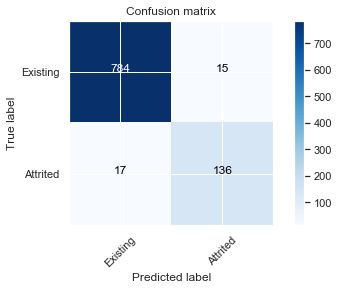

In [172]:
# plot and compute confusion matrix
test_confusion_matrix = confusion_matrix(target_var_test, test_predicted)
churn_labels = [
    'Existing', 'Attrited'
]

plot_confusion_matrix(
    test_confusion_matrix, churn_labels
)

From the confusion matrix, we can see our churn model is not only having a high recall score, but it also has very high accuracy `(~0.97)` and precision `(~0.9)` as well. It is not surprising this model outperform the baseline model I which predict all customers are not attrited.

$\color{blue} {\text{ROC curve}}$

We also plot the ROC (Receiver Operating Characteristic) curve to understand how well our model can distinguish true positives and negatives. 

From below, we can see the ROC curve significantly deviates from the diagonal line (i.e. non-discriminating model) and thus we can conclude our model performs quite well on this aspect.

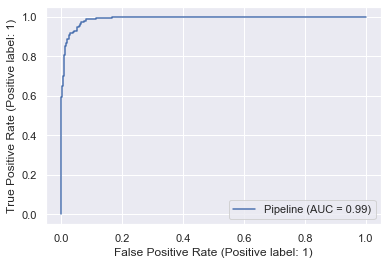

In [173]:
from sklearn import metrics

metrics.plot_roc_curve(final_churn_model, feature_df_test, target_var_test)

$\color{blue} {\text{Churn class predicted probability}}$

Before moving to the next section, we also study the confidence level of our model predictions on the test sets. 

In [174]:
# the predicted churn probability
test_predicted_prob = final_churn_model.predict_proba(feature_df_test)

In [175]:
test_predicted_prob_df = pd.DataFrame(test_predicted_prob)
test_predicted_prob_df.columns = ['non_churn_probability', 'churn_probability']
test_predicted_prob_df.describe()

non_churn_probability  churn_probability
count             952.000000         952.000000
mean                0.512906           0.487094
std                 0.017809           0.017809
min                 0.446003           0.432055
25%                 0.504379           0.482620
50%                 0.510818           0.489182
75%                 0.517380           0.495621
max                 0.567945           0.553997

Looking at the predicted churn probability (on the test set), we can see that although the model performs well on the metric scores, it does not have strong confidence in distinguish between existing and attrited customers in general, with only `10-12%` difference at most in predicted probabilities between churn and not churn.

# feature importance

In [176]:
# Adopted from Kyle Gilde
# https://www.kaggle.com/kylegilde/extracting-scikit-feature-names-importances

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.validation import check_is_fitted
import plotly.express as px


class FeatureImportance:

    """
    
    Extract & Plot the Feature Names & Importance Values from a Scikit-Learn Pipeline.
    
    The input is a Pipeline that starts with a ColumnTransformer & ends with a regression or classification model. 
    As intermediate steps, the Pipeline can have any number or no instances from sklearn.feature_selection.

    Note: 
    If the ColumnTransformer contains Pipelines and if one of the transformers in the Pipeline is adding completely new columns, 
    it must come last in the pipeline. For example, OneHotEncoder, MissingIndicator & SimpleImputer(add_indicator=True) add columns 
    to the dataset that didn't exist before, so there should come last in the Pipeline.
    
    
    Parameters
    ----------
    pipeline : a Scikit-learn Pipeline class where the a ColumnTransformer is the first element and model estimator is the last element
    verbose : a boolean. Whether to print all of the diagnostics. Default is False.
    
    Attributes
    __________
    column_transformer_features :  A list of the feature names created by the ColumnTransformer prior to any selectors being applied
    transformer_list : A list of the transformer names that correspond with the `column_transformer_features` attribute
    discarded_features : A list of the features names that were not selected by a sklearn.feature_selection instance.
    discarding_selectors : A list of the selector names corresponding with the `discarded_features` attribute
    feature_importance :  A Pandas Series containing the feature importance values and feature names as the index.    
    plot_importances_df : A Pandas DataFrame containing the subset of features and values that are actually displaced in the plot. 
    feature_info_df : A Pandas DataFrame that aggregates the other attributes. The index is column_transformer_features. The transformer column contains the transformer_list.
        value contains the feature_importance values. discarding_selector contains discarding_selectors & is_retained is a Boolean indicating whether the feature was retained.
    
    
    
    """
    def __init__(self, pipeline, verbose=False):
        self.pipeline = pipeline
        self.verbose = verbose


    def get_feature_names(self, verbose=None):  

        """

        Get the column names from the a ColumnTransformer containing transformers & pipelines

        Parameters
        ----------
        verbose : a boolean indicating whether to print summaries. 
            default = False


        Returns
        -------
        a list of the correct feature names

        Note: 
        If the ColumnTransformer contains Pipelines and if one of the transformers in the Pipeline is adding completely new columns, 
        it must come last in the pipeline. For example, OneHotEncoder, MissingIndicator & SimpleImputer(add_indicator=True) add columns 
        to the dataset that didn't exist before, so there should come last in the Pipeline.

        Inspiration: https://github.com/scikit-learn/scikit-learn/issues/12525 

        """

        if verbose is None:
            verbose = self.verbose
            
        if verbose: print('''\n\n---------\nRunning get_feature_names\n---------\n''')
        
        column_transformer = self.pipeline[0]        
        assert isinstance(column_transformer, ColumnTransformer), "Input isn't a ColumnTransformer"
        check_is_fitted(column_transformer)

        new_feature_names, transformer_list = [], []

        for i, transformer_item in enumerate(column_transformer.transformers_): 
            
            transformer_name, transformer, orig_feature_names = transformer_item
            orig_feature_names = list(orig_feature_names)
            
            if verbose: 
                print('\n\n', i, '. Transformer/Pipeline: ', transformer_name, ',', 
                      transformer.__class__.__name__, '\n')
                print('\tn_orig_feature_names:', len(orig_feature_names))

            if transformer == 'drop':
                    
                continue
                
            if isinstance(transformer, Pipeline):
                # if pipeline, get the last transformer in the Pipeline
                transformer = transformer.steps[-1][1]

            if hasattr(transformer, 'get_feature_names'):

                if 'input_features' in transformer.get_feature_names.__code__.co_varnames:

                    names = list(transformer.get_feature_names(orig_feature_names))

                else:

                    names = list(transformer.get_feature_names())

            elif hasattr(transformer,'indicator_') and transformer.add_indicator:
                # is this transformer one of the imputers & did it call the MissingIndicator?

                missing_indicator_indices = transformer.indicator_.features_
                missing_indicators = [orig_feature_names[idx] + '_missing_flag'\
                                      for idx in missing_indicator_indices]
                names = orig_feature_names + missing_indicators

            elif hasattr(transformer,'features_'):
                # is this a MissingIndicator class? 
                missing_indicator_indices = transformer.features_
                missing_indicators = [orig_feature_names[idx] + '_missing_flag'\
                                      for idx in missing_indicator_indices]

            else:

                names = orig_feature_names

            if verbose: 
                print('\tn_new_features:', len(names))
                print('\tnew_features:\n', names)

            new_feature_names.extend(names)
            transformer_list.extend([transformer_name] * len(names))
        
        self.transformer_list, self.column_transformer_features = transformer_list,\
                                                                    new_feature_names

        return new_feature_names

    
    def get_selected_features(self, verbose=None):
        """

        Get the Feature Names that were retained after Feature Selection (sklearn.feature_selection)

        Parameters
        ----------
        verbose : a boolean indicating whether to print summaries. default = False

        Returns
        -------
        a list of the selected feature names


        """

        if verbose is None:
            verbose = self.verbose

        assert isinstance(self.pipeline, Pipeline), "Input isn't a Pipeline"

        features = self.get_feature_names()
        
        if verbose: print('\n\n---------\nRunning get_selected_features\n---------\n')
            
        all_discarded_features, discarding_selectors = [], []

        for i, step_item in enumerate(self.pipeline.steps[:]):
            
            step_name, step = step_item

            if hasattr(step, 'get_support'):

                if verbose: print('\nStep ', i, ": ", step_name, ',', 
                                  step.__class__.__name__, '\n')
                    
                check_is_fitted(step)

                feature_mask_dict = dict(zip(features, step.get_support()))
                
                features = [feature for feature, is_retained in feature_mask_dict.items()\
                            if is_retained]
                                         
                discarded_features = [feature for feature, is_retained in feature_mask_dict.items()\
                                      if not is_retained]
                
                all_discarded_features.extend(discarded_features)
                discarding_selectors.extend([step_name] * len(discarded_features))
                
                
                if verbose: 
                    print(f'\t{len(features)} retained, {len(discarded_features)} discarded')
                    if len(discarded_features) > 0:
                        print('\n\tdiscarded_features:\n\n', discarded_features)

        self.discarded_features, self.discarding_selectors = all_discarded_features,\
                                                                discarding_selectors
        
        return features

    def get_feature_importance(self):
        
        """
        Creates a Pandas Series where values are the feature importance values from the model and feature names are set as the index. 
        
        This Series is stored in the `feature_importance` attribute.

        Returns
        -------
        A pandas Series containing the feature importance values and feature names as the index.
        
        """
        
        assert isinstance(self.pipeline, Pipeline), "Input isn't a Pipeline"

        features = self.get_selected_features()
             
        assert hasattr(self.pipeline[-1], 'feature_importances_'),\
            "The last element in the pipeline isn't an estimator with a feature_importances_ attribute"
        
        importance_values = self.pipeline[-1].feature_importances_
        
        assert len(features) == len(importance_values),\
            "The number of feature names & importance values doesn't match"
        
        feature_importance = pd.Series(importance_values, index=features)
        self.feature_importance = feature_importance
        
        # create feature_info_df
        column_transformer_df =\
            pd.DataFrame(dict(transformer=self.transformer_list),
                         index=self.column_transformer_features)

        discarded_features_df =\
            pd.DataFrame(dict(discarding_selector=self.discarding_selectors),
                         index=self.discarded_features)

        importance_df = self.feature_importance.rename('value').to_frame()

        self.feature_info_df = \
            column_transformer_df\
            .join([importance_df, discarded_features_df])\
            .assign(is_retained = lambda df: ~df.value.isna())        


        return feature_importance
        
    
    def plot(self, top_n_features=100, rank_features=True, max_scale=True, 
             display_imp_values=True, display_imp_value_decimals=1,
             height_per_feature=25, orientation='h', width=750, height=None, 
             str_pad_width=15, yaxes_tickfont_family='Courier New', 
             yaxes_tickfont_size=15):
        """

        Plot the Feature Names & Importances 


        Parameters
        ----------

        top_n_features : the number of features to plot, default is 100
        rank_features : whether to rank the features with integers, default is True
        max_scale : Should the importance values be scaled by the maximum value & mulitplied by 100?  Default is True.
        display_imp_values : Should the importance values be displayed? Default is True.
        display_imp_value_decimals : If display_imp_values is True, how many decimal places should be displayed. Default is 1.
        height_per_feature : if height is None, the plot height is calculated by top_n_features * height_per_feature. 
        This allows all the features enough space to be displayed
        orientation : the plot orientation, 'h' (default) or 'v'
        width :  the width of the plot, default is 500
        height : the height of the plot, the default is top_n_features * height_per_feature
        str_pad_width : When rank_features=True, this number of spaces to add between the rank integer and feature name. 
            This will enable the rank integers to line up with each other for easier reading. 
            Default is 15. If you have long feature names, you can increase this number to make the integers line up more.
            It can also be set to 0.
        yaxes_tickfont_family : the font for the feature names. Default is Courier New.
        yaxes_tickfont_size : the font size for the feature names. Default is 15.

        Returns
        -------
        plot

        """
        if height is None:
            height = top_n_features * height_per_feature
            
        # prep the data
        
        all_importances = self.get_feature_importance()
        n_all_importances = len(all_importances)
        
        plot_importances_df =\
            all_importances\
            .nlargest(top_n_features)\
            .sort_values()\
            .to_frame('value')\
            .rename_axis('feature')\
            .reset_index()
                
        if max_scale:
            plot_importances_df['value'] = \
                                plot_importances_df.value.abs() /\
                                plot_importances_df.value.abs().max() * 100
            
        self.plot_importances_df = plot_importances_df.copy()
        
        if len(all_importances) < top_n_features:
            title_text = 'All Feature Importances'
        else:
            title_text = f'Top {top_n_features} (of {n_all_importances}) Feature Importances'       
        
        if rank_features:
            padded_features = \
                plot_importances_df.feature\
                .str.pad(width=str_pad_width)\
                .values
            
            ranked_features =\
                plot_importances_df.index\
                .to_series()\
                .sort_values(ascending=False)\
                .add(1)\
                .astype(str)\
                .str.cat(padded_features, sep='. ')\
                .values

            plot_importances_df['feature'] = ranked_features
        
        if display_imp_values:
            text = plot_importances_df.value.round(display_imp_value_decimals)
        else:
            text = None

        # create the plot 
        
        fig = px.bar(plot_importances_df, 
                     x='value', 
                     y='feature',
                     orientation=orientation, 
                     width=width, 
                     height=height,
                     text=text)
        fig.update_layout(title_text=title_text, title_x=0.5) 
        fig.update(layout_showlegend=False)
        fig.update_yaxes(tickfont=dict(family=yaxes_tickfont_family, 
                                       size=yaxes_tickfont_size),
                         title='')
        fig.show()

In [177]:
# Label the feature variables as X and target as Y
X = feature_df
y = target_var
    
# fit and predict
final_churn_model.fit(X, y)

feature_importance = FeatureImportance(final_churn_model)
feature_importance.plot(top_n_features=25)

From the above, we can see almost all numerical variables (except the number of dependents) are more relevant in predicting customer churn, with the top 5 more important features being `[Total_Trans_Amt, Total_Trans_Ct, Total_Amt_Chng_Q4_Q1, Credit_Limit, Avg_Utilization_Ratio]`.

$\color{blue} {\text{Aside: Feature Selection, removing the least important features in the model}}$

Here we will perform some feature selection and study if removing the least important features help improve our model performance. In particular, we will remove the features `[Marital_Status, Card_Category, Gender, Dependent_Count]`.  

In [178]:
from sklearn.preprocessing import OrdinalEncoder

# numerical colummns 
selected_numerical_columns = [
    col for col in numerical_columns if col != 'Dependent_count'
]

# ordinal columns
selected_ordinal_columns = [
    'Education_Level',
    'Income_Category'
]

# Ordinal labels order
education_categories = [
    'Unknown', 'Uneducated', 'High School', 'College',  
    'Graduate', 'Post-Graduate', 'Doctorate'
]
income_categories = [
    'Unknown', 'Less than $40K', '$40K - $60K', '$60K - $80K', 
    '$80K - $120K', '$120K +'
]

# Ordinal encoder (with card category removed)
selected_ordinal_encoder = OrdinalEncoder(
    categories=[education_categories, income_categories],
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

In [179]:
from sklearn.compose import ColumnTransformer

selected_full_preprocessing_pipeline = ColumnTransformer(
    [
        ('numeric', 'passthrough', selected_numerical_columns),
        ('ordinal', selected_ordinal_encoder, selected_ordinal_columns)
    ],
    remainder='drop'
)

In [180]:
# new model with some least important features dropped

from sklearn.ensemble import AdaBoostClassifier

# final churn model, with feature selection
selected_final_churn_model = Pipeline(
    steps=[
        ('preprocessing', selected_full_preprocessing_pipeline),
        ('predictor', AdaBoostClassifier(n_estimators=200, learning_rate=1.0))
    ]
)
    
# Label the feature variables as X and target as Y
X = feature_df
y = target_var
    
# fit and predict
selected_final_churn_model.fit(X, y)
selected_train_predicted = selected_final_churn_model.predict(X)
selected_test_predicted = selected_final_churn_model.predict(feature_df_test)

# compute recall scores
selected_recall_train_score = recall_score(
    y, selected_train_predicted 
)
selected_recall_test_score = recall_score(
    target_var_test, selected_test_predicted  
)

In [181]:
# print the train and test recall score
print(f'Final train recall score: {round(selected_recall_train_score, 2)}')
print(f'Final test recall score: {round(selected_recall_test_score, 2)}')

Final train recall score: 0.89
Final test recall score: 0.88


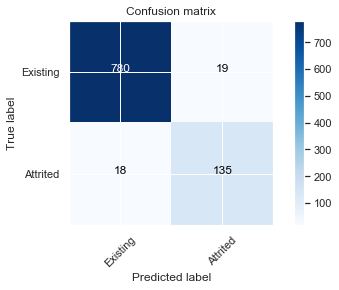

In [182]:
# plot and compute confusion matrix, with feature selection
selected_test_confusion_matrix = confusion_matrix(target_var_test, selected_test_predicted)
churn_labels = [
    'Existing', 'Attrited'
]

plot_confusion_matrix(
    selected_test_confusion_matrix, churn_labels
)

We found that the model performance is very much the same as the previous one which uses all the feature variables. 

One may therefore use as this one as the final model as it has less feature dimensions and are less susceptible to overfitting.

$\color{green} {\text{Aside: further investigations or other things to try out to improve the model}}$

1) collect more churn data to make the dataset more balanced in terms of customer churn

2) resampling the dataset to balance out the churn class

3) explore anomaly detection and change detection methods

4) decompose the existing customers into smaller number of other classes to balance out the classes

5) impute the "Unknown" categorical entries

6) perform dimension reduction on the features after preprocessing

## 3) Predict churn on unseen data

Finally we are about to use our trained ML model to predict customer churn in the unseen dataset and investigate how the model may perform on some real customer data.

In [183]:
unseen = pd.read_csv('datasets/unseen_data.csv')
unseen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507 entries, 0 to 506
Data columns (total 20 columns):
CLIENTNUM                   507 non-null int64
Customer_Age                507 non-null int64
Gender                      507 non-null object
Dependent_count             507 non-null int64
Education_Level             507 non-null object
Marital_Status              507 non-null object
Income_Category             507 non-null object
Card_Category               507 non-null object
Months_on_book              507 non-null int64
Total_Relationship_Count    507 non-null int64
Months_Inactive_12_mon      507 non-null int64
Contacts_Count_12_mon       507 non-null int64
Credit_Limit                507 non-null float64
Total_Revolving_Bal         507 non-null int64
Avg_Open_To_Buy             507 non-null float64
Total_Amt_Chng_Q4_Q1        507 non-null float64
Total_Trans_Amt             507 non-null int64
Total_Trans_Ct              507 non-null int64
Total_Ct_Chng_Q4_Q1         507 non-nu

In [184]:
unseen.describe()

CLIENTNUM  Customer_Age  Dependent_count  Months_on_book  \
count  5.070000e+02    507.000000       507.000000      507.000000   
mean   7.380607e+08     46.043393         2.289941       35.790927   
std    3.786756e+07      7.978608         1.296376        8.346479   
min    7.080855e+08     26.000000         0.000000       13.000000   
25%    7.127481e+08     40.500000         1.000000       31.000000   
50%    7.170450e+08     46.000000         2.000000       36.000000   
75%    7.719381e+08     51.000000         3.000000       41.000000   
max    8.282919e+08     67.000000         5.000000       56.000000   

       Total_Relationship_Count  Months_Inactive_12_mon  \
count                507.000000              507.000000   
mean                   3.850099                2.266272   
std                    1.496113                0.968938   
min                    1.000000                1.000000   
25%                    3.000000                2.000000   
50%                    4.000000                2.000000   
75%                    5.000000                3.000000   
max                    6.000000                6.000000   

       Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
count             507.000000    507.000000           507.000000   
mean                2.491124   8700.505917          1176.706114   
std                 1.085941   9356.681332           840.994507   
min                 0.000000   1438.300000             0.000000   
25%                 2.000000   2558.000000             0.000000   
50%                 3.000000   4440.000000          1272.000000   
75%                 3.000000  11110.000000          1866.000000   
max                 6.000000  34516.000000          2517.000000   

       Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
count       507.000000            507.000000       507.000000      507.000000   
mean       7523.799803              0.760249      4614.179487       66.633136   
std        9346.879862              0.203981      3598.699193       24.122045   
min          79.000000              0.166000       646.000000       10.000000   
25%        1254.500000              0.631000      2250.500000       46.000000   
50%        3344.000000              0.735000      4078.000000       69.000000   
75%        9463.500000              0.845500      4798.000000       82.000000   
max       34516.000000              1.608000     17498.000000      127.000000   

       Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
count           507.000000             507.000000  
mean              0.734503               0.277353  
std               0.234276               0.279666  
min               0.162000               0.000000  
25%               0.605500               0.000000  
50%               0.718000               0.174000  
75%               0.841000               0.542000  
max               2.875000               0.953000

We can see this unseen dataset has 507 entries, all of them non-null. Before we move to predict customer churn in this unseen dataset, let us first investigate and ensure there isn't any duplicate customers/entries which also appear in our previous training dataset (and within the unseen dataset itself as well).

In [185]:
# check no duplicates
unseen_customer_ids = unseen['CLIENTNUM']
number_of_rows_unseen = len(unseen_customer_ids)
number_of_unique_ids_unseen = unseen_customer_ids.nunique()

if number_of_rows_unseen == number_of_unique_ids_unseen:
    print(f'All {number_of_rows_unseen} customer IDs are unique')
else:
    number_of_repeated_ids_unseen = number_of_rows_unseen - number_of_unique_ids_unseen
    print(f'There exists some {number_of_repeated_ids_unseen} repeated customer IDs')

All 507 customer IDs are unique


In [186]:
# check to ensure no duplicated row entries (except customer ID)
unseen_check_duplicated = unseen.iloc[:, 1:].duplicated()
sum(unseen_check_duplicated)

0

In [187]:
unseen_customer_ids = set(unseen_customer_ids)
seen_customer_ids = set(churn_data_with_id['CLIENTNUM'])

intersection_customer_ids = unseen_customer_ids.intersection(seen_customer_ids)
intersection_customer_ids

set()

In [188]:
combined_data = churn_data_with_id.append(unseen)
combined_data = combined_data[
    [col for col in combined_data.columns if col != 'CLIENTNUM']
]

combined_check_duplicated = combined_data.duplicated()
sum(combined_check_duplicated)

0

We confirm this unseen dataset is indeed entirely new and does not contain any duplicate customers/entries that appear in the previous training churn dataset. 

Next we investigate if the training and/or test are good representative of the unseen dataset, in other words, the feature variables have similar distributions.

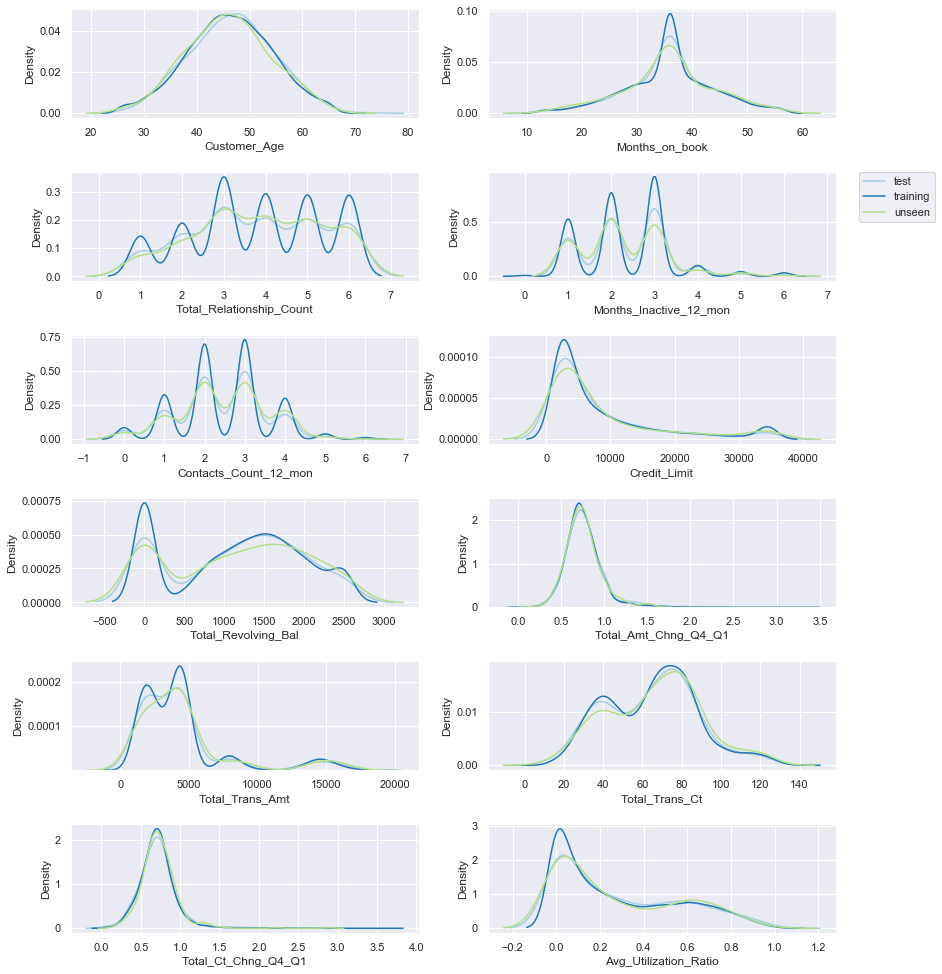

In [189]:
colours = sns.color_palette("Paired")
fig, ax = plt.subplots(nrows=6, ncols=2, figsize = (12, 14))
fig.tight_layout(pad=2.5)

# KDE distribution plots for selected numerical variables across different datasets
i=0
for col in selected_numerical_columns:
    j = i // 2
    k = i % 2
    for p, dataset in enumerate([feature_df_test, feature_df, unseen]):
        sns.kdeplot(
            data=dataset, x=col, ax=ax[j][k], color=colours[p]
        )

    plt.legend(
        ['test', 'training', 'unseen'], bbox_to_anchor=(1.05, 7), loc='upper left'
    )
    i+=1

In [190]:
dataset_train = feature_df.copy()
dataset_test = feature_df_test.copy()
dataset_new = unseen.copy()

dataset_train['dataset_type'] = ['train'] * len(dataset_train)
dataset_test['dataset_type'] = ['test'] * len(dataset_test)
dataset_new['dataset_type'] = ['unseen'] * len(dataset_new)

combined_dataset_df = dataset_train.append(dataset_test)
combined_dataset_df = combined_dataset_df.append(dataset_new)

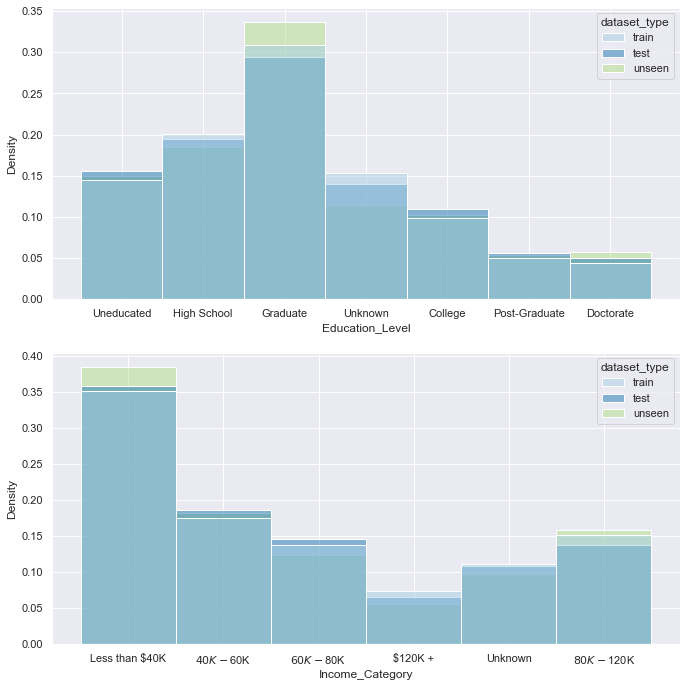

In [191]:
colours = sns.color_palette("Paired")
fig, ax = plt.subplots(nrows=2, figsize =(10, 10))
fig.tight_layout(pad=2.5)

# distribution plots for the selected categorical variables across different datasets
i=0
for col in selected_ordinal_columns:
    
    sns.histplot(
        combined_dataset_df, x=col, hue="dataset_type", element="bars",
        stat="density", common_norm=False, ax=ax[i],
        palette=colours[:3]
    )
    i+=1

From the above, we can see the feature variables do have similar distributions across the datasets and thus the training dataset is a good representative of the unseen data. We can now move to predict churn in this new unseen dataset. 

In [192]:
# select and reorder the feature columns such that the order is the same as the training data
unseen_feature = unseen[
    feature_df.columns
]

In [193]:
# predict customer churn in this unseen dataset
unseen_churn_predicted = selected_final_churn_model.predict(unseen_feature)

In [194]:
churn_total = np.sum(unseen_churn_predicted)
not_churn_total = np.sum(unseen_churn_predicted == 0)

In [195]:
churn_total, not_churn_total

(73, 434)

We can see our model predicts 73 customers are attrited, which accounts for around `16%` of the customers in the unseen dataset. 

However, in practice, we probably would be more interested in the predicted probability, or in other words, the confidence level of predicting a customer to be attrited. 

In [196]:
# predict customer churn probability
unseen_churn_predicted_prob = selected_final_churn_model.predict_proba(unseen_feature)

In [197]:
churn_prob = [
    pred_prob[1] for pred_prob in unseen_churn_predicted_prob 
]

In [198]:
churn_prob_df = pd.DataFrame({'churn_probability': churn_prob})
churn_prob_df.describe()

churn_probability
count         507.000000
mean            0.485663
std             0.017472
min             0.432677
25%             0.481829
50%             0.487884
75%             0.494928
max             0.559770

In [199]:
churn_prob_df['CLIENTNUM'] = unseen['CLIENTNUM']
churn_prob_df.set_index('CLIENTNUM', inplace=True)
churn_prob_df.head(10)

churn_probability
CLIENTNUM                   
712411908           0.490184
718892283           0.487289
718259433           0.505853
708748833           0.472231
710839308           0.479381
810974958           0.500798
816776283           0.483449
715249533           0.442313
721091583           0.487350
708323208           0.506674

Above we show the results of the predicted churn probability of the first few customers. We can see the predicted probabilities are not quite high and lie within the range of `0.43-0.56`.

In [200]:
# The list of customers who are predicted to be attrited 
churn_prob_df[churn_prob_df['churn_probability'] > 0.5].index

Int64Index([718259433, 810974958, 708323208, 715950483, 713011683, 712552608,
            716349183, 708385533, 715487733, 710241858, 820047858, 779844408,
            720698883, 793630083, 779348358, 713886333, 711819708, 820288233,
            708496833, 767266758, 796931508, 721306908, 715493733, 817607358,
            719123958, 789052308, 720128658, 711791583, 708266883, 717368208,
            709663608, 714006333, 719821908, 713526258, 719512983, 712783083,
            714164808, 716564433, 713261133, 787482033, 714484008, 711456108,
            710570058, 720903258, 713748708, 720991833, 714945708, 719714658,
            720426708, 772695033, 716223708, 816850458, 794124708, 771561183,
            709608708, 709713033, 719818983, 719326758, 716863458, 712979133,
            720719883, 714684933, 713229633, 716893683, 716272158, 708654933,
            713206683, 710155983, 714377058, 719860308, 794965233, 716506083,
            714615258],
           dtype='int64', name='CLIENTNU

# Some notes for non-technical audience:

Here we have used the Adaptive Boost (AdaBoost) classifier to predict customer churn in the datasets. In brief, this model is a boosted decision tree based ML model.

A decision tree is a graphical representation of all the possible solutions to a decision based on certain conditions, see the below figure for a very simple example. 

Tree depth is a measure of how many splits a tree can make before coming to a prediction. For the below simple example, the depth is 2.

In [201]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://miro.medium.com/max/820/1*JAEY3KP7TU2Q6HN6LasMrw.png")

In machine learning, the term 'Boosting' refers to a family of algorithms which converts weak learner to strong learners. Boosting is an example of ensemble methods, which use a collection of ML models to improve the final model predictions. In particular, the idea of boosting is to train weak learners sequentially, each trying to correct its predecessor.

Some examples of good non-technical explanations on decisions trees, random forest and related boosted tree-based algorithms.
https://www.quora.com/How-would-you-explain-the-concept-of-gradient-boosted-trees-to-a-non-technical-audience

Here in our specific churn model, we have used the adaptive boosting method on a collection of simple decision tree models (max depth = 1).

In [202]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://miro.medium.com/max/1600/0*qCcM7uCOqIw6npnJ.png")

To evaluate the model performance, here we have used the recall score instead of a simple accuracy score (i.e. % of accurate predictions across the whole dataset). 

This is because the dataset is imbalanced in customer churn and we are mostly interested in predicting whether a customer is likely to be attrited or not. Wrongly predicting an attrited customer (false negatives) in general causes more damage to the company business as compared to wrongly predicting an existing customer to be attrited (unless the business offers massive promotion schemes to potential attrited customers).

Therefore the recall score, which is essentially the % of accurate predictions within attrited customers, is more relevant here.

# Summary

Based on the datasets given, the ML model on predicting customer churn we built have a quite good predictive power, with a higher accuracy `(~0.97)` and recall scores `(~0.88)`. The model does not give very high corresponding confidence levels though. 

Our model suggests if we would like to monitor whether a customer is likely to become attrited in future, we should look at `[Total_Trans_Amt, Total_Trans_Ct, Total_Amt_Chng_Q4_Q1]`.

# Further direction(s)

As credit card product owners, we are ususally more interested in big-spenders and loyal customers who have regular frequent transactions. We may want to understand in more depth the churn rate of these type of customers and how one may reduce it.

To investigate this, we can use unsupervised algorithms to find different customer clusters (based on their behviour e.g. average spent amount per transactions). Then study how likely different (unsupervised) cluster groups of customers may become attrited.

# Final Remarks

When using this model to predict customer churn, one needs to be aware that there can be some hidden (economic) factors that may be different in this dataset as compared to the training data, e.g. inflation rate, tax rate, country GDP, etc. If there are some significant difference in these hidden factors between the training and new unseen dataset, one should not blindly trust the ML model predictions without doing some further investigation on how these hidden factors may affect the customer behaviour.

On the extreme, take the current COVID pandemic as an example. Clearly the pandemic significantly alter the way we live, with particularly a dramatic increase in online shopping. If the training dataset comes from the pre-COVID era whereas the unseen dataset are COVID era, we do not expect our model would have the same predictive power on this unseen dataset.

A potential walkaround would be to adjust the variables accordingly, e.g. use `total transaction amount adjusted for inflation` instead.